# Data load and imports

In [124]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.gridspec as gridspec

from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Functions

In [125]:
"""Cumulative sum algorithm (CUSUM) to detect abrupt changes in data."""

from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"


def detect_cusum(data, threshold=1, drift=0, estimate_end=False, plot=True, ax=None):
    """
    Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    data : 1D array_like
        Input data.
    threshold : float, optional (default=1)
        Amplitude threshold for detecting changes.
    drift : float, optional (default=0)
        Drift term to prevent false detections in the absence of changes.
    estimate_end : bool, optional (default=False)
        If True, estimates when the change ends.
    plot : bool, optional (default=True)
        If True, plots the results.
    ax : matplotlib.axes.Axes, optional
        Axes instance for plotting.

    Returns
    -------
    alarm_times : np.ndarray
        Indices where changes are detected.
    start_indices : np.ndarray
        Indices where changes start.
    end_indices : np.ndarray
        Indices where changes end (if `estimate_end` is True).
    amplitudes : np.ndarray
        Amplitudes of changes (if `estimate_end` is True).
    """
    # Ensure input is a 1D array of type float64
    data = np.atleast_1d(data).astype('float64')

    # Initialize variables
    positive_cumsum = np.zeros(data.size)
    negative_cumsum = np.zeros(data.size)
    alarm_times, start_indices, end_indices = np.array([[], [], []], dtype=int)
    last_positive_reset, last_negative_reset = 0, 0
    amplitudes = np.array([])

    # Detect changes (online form)
    for i in range(1, data.size):
        diff = data[i] - data[i - 1]
        positive_cumsum[i] = positive_cumsum[i - 1] + diff - drift
        negative_cumsum[i] = negative_cumsum[i - 1] - diff - drift

        # Reset cumulative sums if they drop below zero
        if positive_cumsum[i] < 0:
            positive_cumsum[i], last_positive_reset = 0, i
        if negative_cumsum[i] < 0:
            negative_cumsum[i], last_negative_reset = 0, i

        # Detect changes if cumulative sums exceed the threshold
        if positive_cumsum[i] > threshold or negative_cumsum[i] > threshold:
            alarm_times = np.append(alarm_times, i)
            start_indices = np.append(
                start_indices,
                last_positive_reset if positive_cumsum[i] > threshold else last_negative_reset
            )
            positive_cumsum[i], negative_cumsum[i] = 0, 0  # Reset alarms

    # Estimate when changes end (offline form)
    if start_indices.size and estimate_end:
        _, reversed_start_indices, _, _ = detect_cusum(data[::-1], threshold, drift, plot=False)
        end_indices = data.size - reversed_start_indices[::-1] - 1

        # Remove duplicate changes
        start_indices, unique_indices = np.unique(start_indices, return_index=True)
        alarm_times = alarm_times[unique_indices]

        if start_indices.size != end_indices.size:
            if start_indices.size < end_indices.size:
                end_indices = end_indices[[np.argmax(end_indices >= i) for i in alarm_times]]
            else:
                indices = [np.argmax(i >= alarm_times[::-1]) - 1 for i in end_indices]
                alarm_times = alarm_times[indices]
                start_indices = start_indices[indices]

        # Remove intercalated changes
        overlaps = end_indices[:-1] - start_indices[1:] > 0
        if overlaps.any():
            alarm_times = alarm_times[~np.append(False, overlaps)]
            start_indices = start_indices[~np.append(False, overlaps)]
            end_indices = end_indices[~np.append(overlaps, False)]

        # Calculate amplitudes of changes
        amplitudes = data[end_indices] - data[start_indices]

    # Plot results if requested
    if plot:
        _plot_results(data, threshold, drift, estimate_end, ax, alarm_times, start_indices, end_indices, positive_cumsum, negative_cumsum)

    return alarm_times, start_indices, end_indices, amplitudes


def _plot_results(data, threshold, drift, estimate_end, ax, alarm_times, start_indices, end_indices, positive_cumsum, negative_cumsum):
    """
    Plot the results of the detect_cusum function.

    Parameters
    ----------
    data : np.ndarray
        Input data.
    threshold : float
        Threshold for detecting changes.
    drift : float
        Drift term.
    estimate_end : bool
        Whether to estimate when changes end.
    ax : matplotlib.axes.Axes
        Axes instance for plotting.
    alarm_times : np.ndarray
        Indices where changes are detected.
    start_indices : np.ndarray
        Indices where changes start.
    end_indices : np.ndarray
        Indices where changes end.
    positive_cumsum : np.ndarray
        Positive cumulative sum.
    negative_cumsum : np.ndarray
        Negative cumulative sum.
    """
    if ax is None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
    else:
        ax1, ax2 = ax, ax.twinx()

    time = range(data.size)

    # Plot the data and detected changes
    ax1.plot(time, data, 'b-', lw=2)
    if len(alarm_times):
        ax1.plot(start_indices, data[start_indices], '>', mfc='g', mec='g', ms=10, label='Start')
        if estimate_end:
            ax1.plot(end_indices, data[end_indices], '<', mfc='g', mec='g', ms=10, label='End')
        ax1.plot(alarm_times, data[alarm_times], 'o', mfc='r', mec='r', mew=1, ms=5, label='Alarm')
        ax1.legend(loc='best', framealpha=0.5, numpoints=1)

    ax1.set_xlim(-0.01 * data.size, data.size * 1.01 - 1)
    ax1.set_xlabel('Data Index', fontsize=14)
    ax1.set_ylabel('Amplitude', fontsize=14)
    ax1.set_title(f'Detected Changes (Threshold={threshold}, Drift={drift})')

    # Plot cumulative sums
    ax2.plot(time, positive_cumsum, 'y-', label='Positive Cumsum')
    ax2.plot(time, negative_cumsum, 'm-', label='Negative Cumsum')
    ax2.axhline(threshold, color='r', linestyle='--', label='Threshold')
    ax2.legend(loc='best', framealpha=0.5, numpoints=1)

    plt.tight_layout()
    plt.show()


## Loading data

In [ ]:
df = pd.read_csv("./dataset/filtered_data.csv")
df.set_index('Data e Hora', drop=True, inplace=True)

df.fillna(0, inplace=True)

df.index = pd.to_datetime(df.index)

title = 'Energy production (2011 - 2025)'

title_renewable = 'Renewable Energy Production (2011 - 2025)'
title_non_renewable = 'Non-Renewable Energy Production (2011 - 2025)'
title_export = 'Energy Exportation (2011 - 2025)'
title_import = 'Energy Importation (2011 - 2025)'

serie = "Energy Production"
serie_renewable = "Energy Renewable"
serie_non_renewable = "Energy Non-Renewable"
serie_export = "Energy Exportation"
serie_import = "Energy Importation"

xlab = 'days'
ylab = 'Energy Production (GWh)'

seasonal_periods = 365

# Use a color palette with 4 distinct colors
colors = sns.color_palette("Set2")

color_non_renewable = colors[0]
color_renewable = colors[1]
color_export = colors[2]
color_import = colors[3]
color_total_energy = colors[4]
color_net_market = colors[5]

#### Nota 
- Nota: Aplicando uma escala logarítmica aos dados, pode transformar um modelo multiplicativo num aditivo
#### Tipo de modelo que esperamos:
- 'additive' - A amplitude do efeito sazonal mantém-se constante todos os anos
- 'multiplicative' - Os efeitos sazonais e outros atuam proporcionalmente sobre a série

In [127]:
renewable_columns = ['producao_renovavel', 'hidrica',
                     'biomassa', 'eolica', 'solar', 'ondas']

non_renewable_columns = ['producao_nao_renovavel', 'termica',
                         'gas_natural', 'carvao', 'producao_por_bombagem']

market_columns = ['exportacao', 'importacao']

# Análise Descritiva

## Informação geral

In [128]:
df.head()

producao_total  producao_renovavel    hidrica     eolica  \
Data e Hora                                                             
2011-01-01       107.975628           73.076341  63.952042   2.142578   
2011-01-02       109.657562           71.219553  62.732572   1.469945   
2011-01-03       150.642916           74.660080  63.158904   4.503582   
2011-01-04       159.833303          101.106584  64.904843  28.734425   
2011-01-05       170.854279          133.687873  67.566754  58.869586   

                solar  ondas  biomassa  producao_nao_renovavel   carvao  \
Data e Hora                                                               
2011-01-01   0.122491    0.0  6.859230               34.484478   4.3443   
2011-01-02   0.197608    0.0  6.819428               37.876984   0.7383   
2011-01-03   0.166772    0.0  6.830821               74.808327  14.9438   
2011-01-04   0.256511    0.0  7.210805               58.567678   4.8496   
2011-01-05   0.208719    0.0  7.042814               36.428947   4.6337   

             gas_natural   termica  producao_por_bombagem  importacao  \
Data e Hora                                                             
2011-01-01     28.367837  1.772341               0.414810     12.4186   
2011-01-02     35.343969  1.794715               0.561025     20.8615   
2011-01-03     55.179956  4.684572               1.174509     13.4903   
2011-01-04     48.985982  4.732096               0.159041      9.3552   
2011-01-05     27.003927  4.791320               0.737460      6.7881   

             exportacao  
Data e Hora              
2011-01-01       0.0852  
2011-01-02       0.0000  
2011-01-03       1.0916  
2011-01-04       0.7629  
2011-01-05       6.8363

In [129]:
df.tail()

producao_total  producao_renovavel    hidrica     eolica  \
Data e Hora                                                             
2025-03-07       177.437325          167.794250  60.929025  92.925450   
2025-03-08       157.451600          148.972325  39.877775  92.513250   
2025-03-09       161.868975          150.504125  79.291275  51.751675   
2025-03-10       199.013550          185.290575  96.124300  74.644600   
2025-03-11       172.080425          162.225600  94.821575  45.256750   

                 solar  ondas  biomassa  producao_nao_renovavel  carvao  \
Data e Hora                                                               
2025-03-07    6.146575    0.0  7.793200                9.643075     0.0   
2025-03-08    9.159200    0.0  7.422100                8.479275     0.0   
2025-03-09   12.340600    0.0  7.120575               11.364850     0.0   
2025-03-10    7.401925    0.0  7.119750               13.722975     0.0   
2025-03-11   14.878150    0.0  7.269125                9.854825     0.0   

             gas_natural   termica  producao_por_bombagem  importacao  \
Data e Hora                                                             
2025-03-07      9.643075  0.574650              17.072975   16.271075   
2025-03-08      8.479275  0.546325              24.263725   15.114600   
2025-03-09     11.364850  0.380075              18.674825   12.902925   
2025-03-10     13.722975  0.396100               1.909750    0.795300   
2025-03-11      9.854825  0.565875              13.069675   10.395200   

             exportacao  
Data e Hora              
2025-03-07    12.028075  
2025-03-08     1.097875  
2025-03-09    17.361925  
2025-03-10    29.436700  
2025-03-11     7.055600

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5184 entries, 2011-01-01 to 2025-03-11
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   producao_total          5184 non-null   float64
 1   producao_renovavel      5184 non-null   float64
 2   hidrica                 5184 non-null   float64
 3   eolica                  5184 non-null   float64
 4   solar                   5184 non-null   float64
 5   ondas                   5184 non-null   float64
 6   biomassa                5184 non-null   float64
 7   producao_nao_renovavel  5184 non-null   float64
 8   carvao                  5184 non-null   float64
 9   gas_natural             5184 non-null   float64
 10  termica                 5184 non-null   float64
 11  producao_por_bombagem   5184 non-null   float64
 12  importacao              5184 non-null   float64
 13  exportacao              5184 non-null   float64
dtypes: float64(14)
memory 

- producao_renovavel é a agregação das colunas hidrica, eolica, solar, ondas, biomassa
- producao_nao_renovavel é a agregação das colunas carvao, gas_natural, termica, producao_por_bombagem


In [131]:
from IPython.display import display

renewable_stats = df[renewable_columns].describe(
    percentiles=[.1, .25, .5, .75, .9]).T
non_renewable_stats = df[non_renewable_columns].describe(
    percentiles=[.1, .25, .5, .75, .9]).T
market_stats = df[market_columns].describe(
    percentiles=[.1, .25, .5, .75, .9]).T


print("Renewable Energy Statistics:")
display(renewable_stats)

print("Non-Renewable Energy Statistics:")
display(non_renewable_stats)

print("Market Statistics:")
display(market_stats)

Renewable Energy Statistics:


count       mean        std        min        10%  \
producao_renovavel  5184.0  77.065784  34.632489  18.299956  40.048410   
hidrica             5184.0  32.009741  24.007217   0.868215   8.864291   
biomassa            5184.0   7.851014   0.947693   3.823806   6.750285   
eolica              5184.0  33.211845  21.713759   1.035544   9.889702   
solar               5184.0   3.993181   4.210867   0.069242   0.742012   
ondas               5184.0   0.000002   0.000021   0.000000   0.000000   

                          25%        50%        75%         90%         max  
producao_renovavel  50.898169  68.875179  96.618195  128.620780  212.272075  
hidrica             14.505494  24.354312  42.304424   70.527506  122.893150  
biomassa             7.211157   7.734294   8.456767    9.250690   10.591275  
eolica              16.097322  27.988309  45.535882   66.046655  110.344900  
solar                1.301619   2.548978   4.759454    9.967727   23.073325  
ondas                0.000000   0.000000   0.000000    0.000000    0.000580

Non-Renewable Energy Statistics:


count       mean        std       min        10%  \
producao_nao_renovavel  5184.0  53.503589  27.916107  1.484300  14.193318   
termica                 5184.0   1.064443   0.880599  0.035842   0.502275   
gas_natural             5184.0  33.030483  19.300968  1.484300  10.446370   
carvao                  5184.0  19.540515  17.559498 -0.945500  -0.115900   
producao_por_bombagem   5184.0   4.989914   4.771888  0.000000   0.765965   

                              25%        50%        75%        90%         max  
producao_nao_renovavel  30.732008  54.640341  74.151751  90.515868  122.005652  
termica                  0.658859   0.803490   1.060563   1.846109    5.448198  
gas_natural             16.213748  29.939016  47.724280  61.533462   88.414947  
carvao                   0.000000  21.715650  37.332700  41.560490   42.206300  
producao_por_bombagem    1.819474   3.461296   6.495633  11.569438   41.707400

Market Statistics:


count       mean        std  min       10%       25%       50%  \
exportacao  5184.0   9.334745  11.752865  0.0  0.000000  0.481800   4.41350   
importacao  5184.0  18.361303  16.104776  0.0  0.915303  5.192075  14.42055   

                  75%        90%        max  
exportacao  14.180225  26.514695  78.421800  
importacao  27.896700  42.010050  80.739225

## Visualização dos dados

### Visão geral

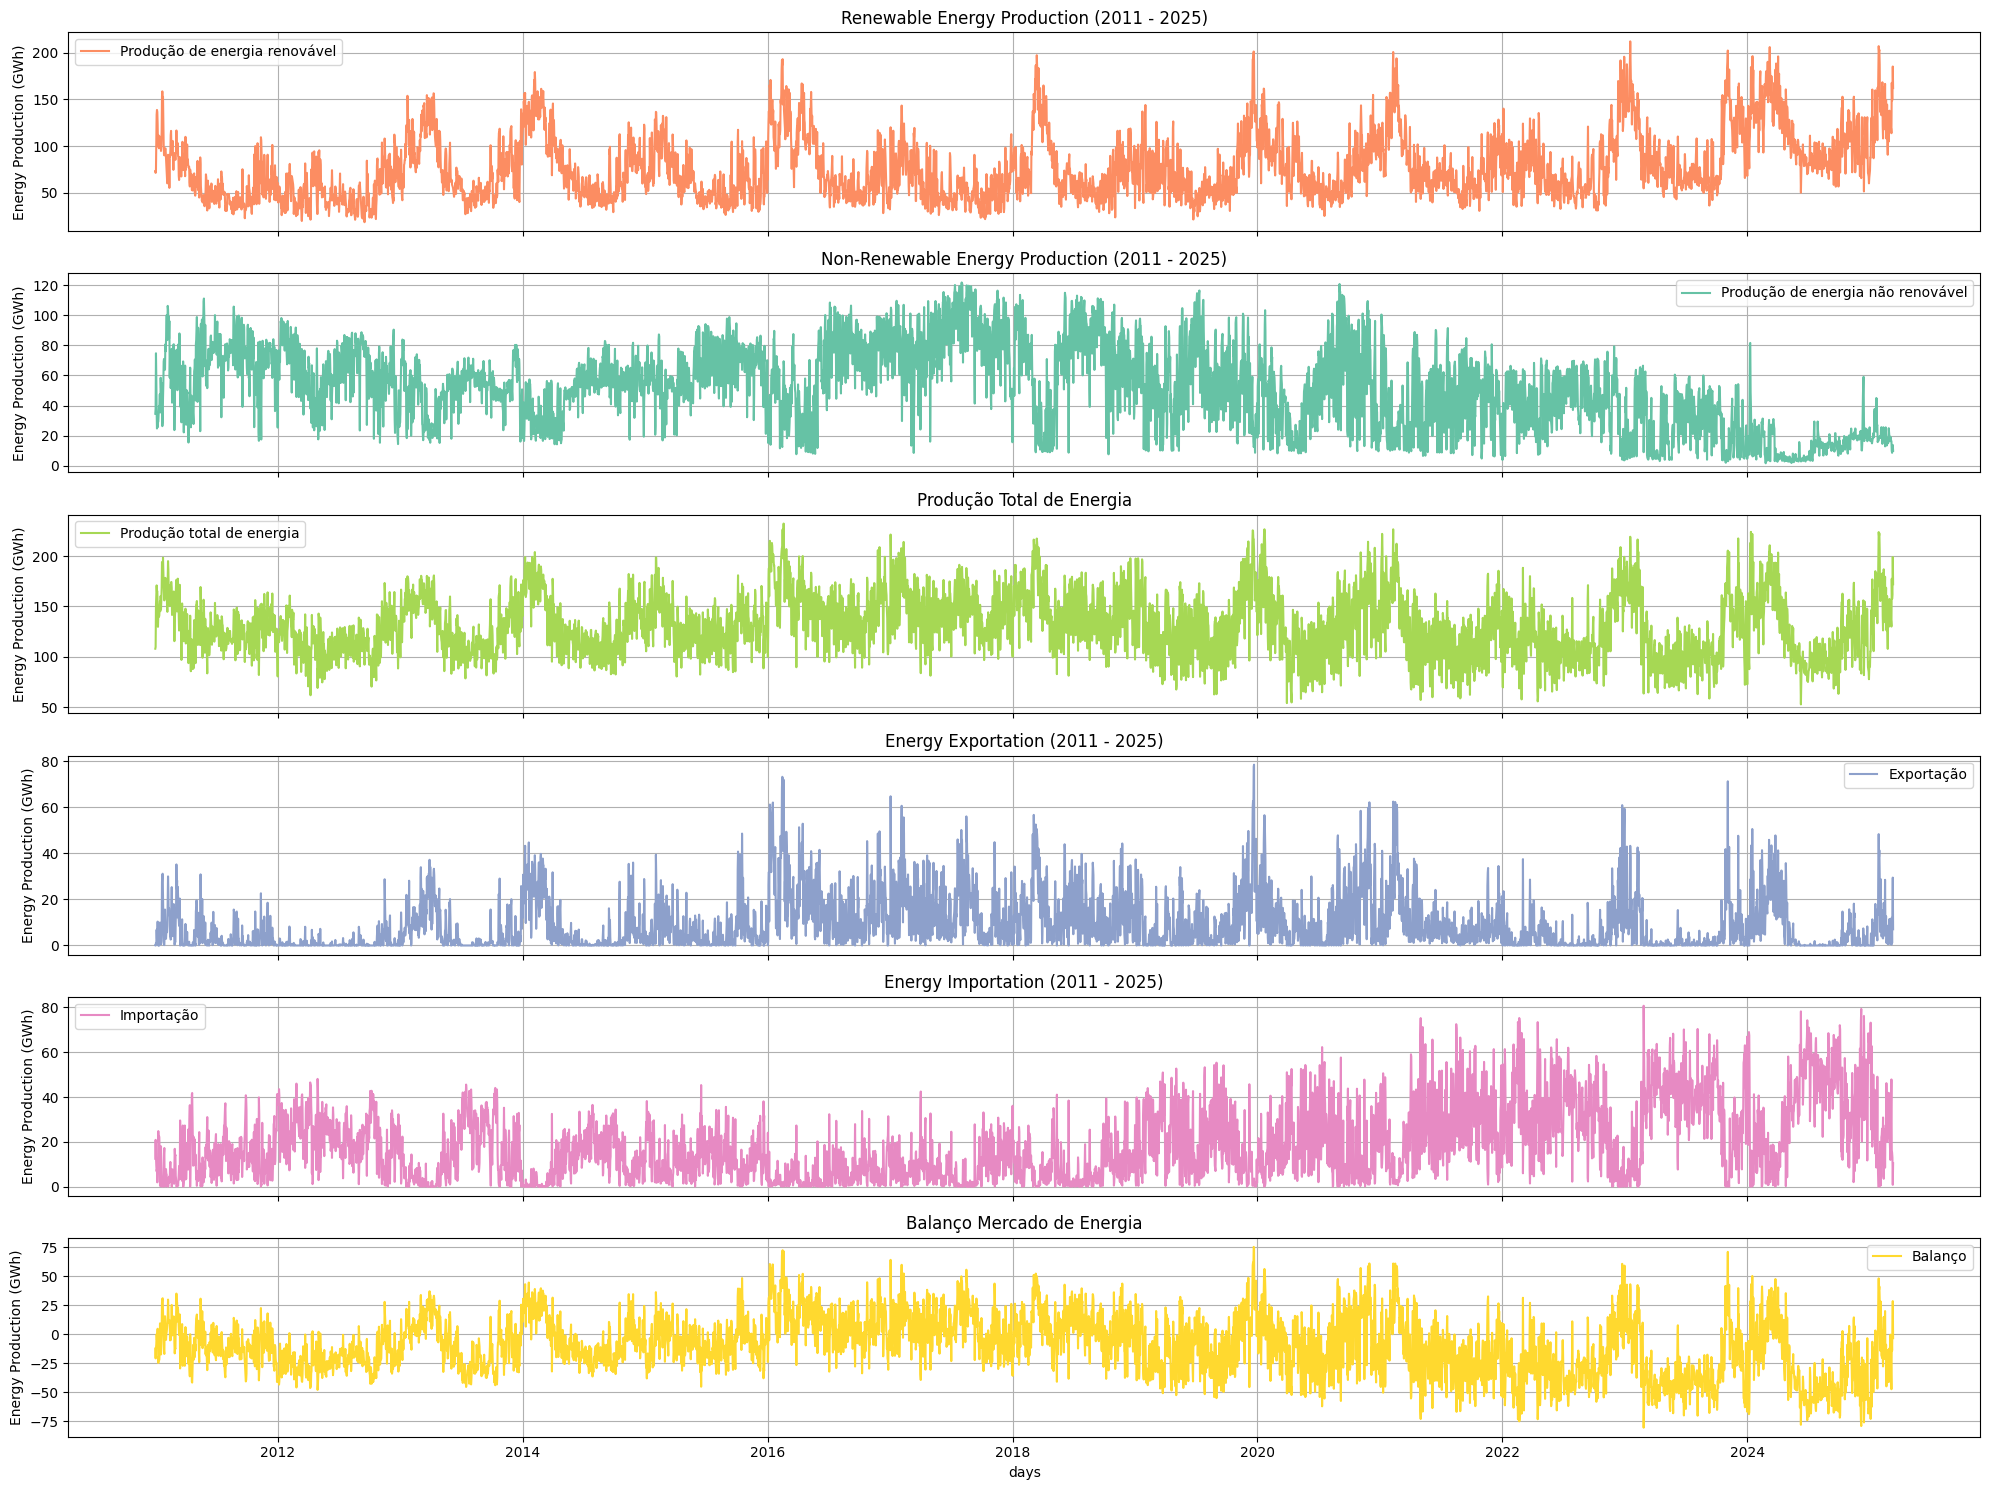

In [132]:
df['liquidez_energia'] = df['exportacao'] - df['importacao']

# Data for plots
plot_data = [
    ('producao_renovavel', title_renewable,
     color_renewable, 'Produção de energia renovável'),
    ('producao_nao_renovavel', title_non_renewable,
     color_non_renewable, 'Produção de energia não renovável'),
    ('producao_total', 'Produção Total de Energia',
     colors[4], 'Produção total de energia'),
    ('exportacao', title_export, color_export, 'Exportação'),
    ('importacao', title_import, color_import, 'Importação'),
    ('liquidez_energia', 'Balanço Mercado de Energia', colors[5], 'Balanço')
]

fig, axes = plt.subplots(len(plot_data), 1, figsize=(20, 15), sharex=True)

# Loop through data to create subplots
for ax, (column, title, color, label) in zip(axes, plot_data):
    ax.plot(df.index, df[column], label=label, color=color)
    ax.set_title(title)
    ax.set_ylabel(ylab)
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel(xlab)  # Set x-axis label for the last subplot
plt.tight_layout()

### Histogramas

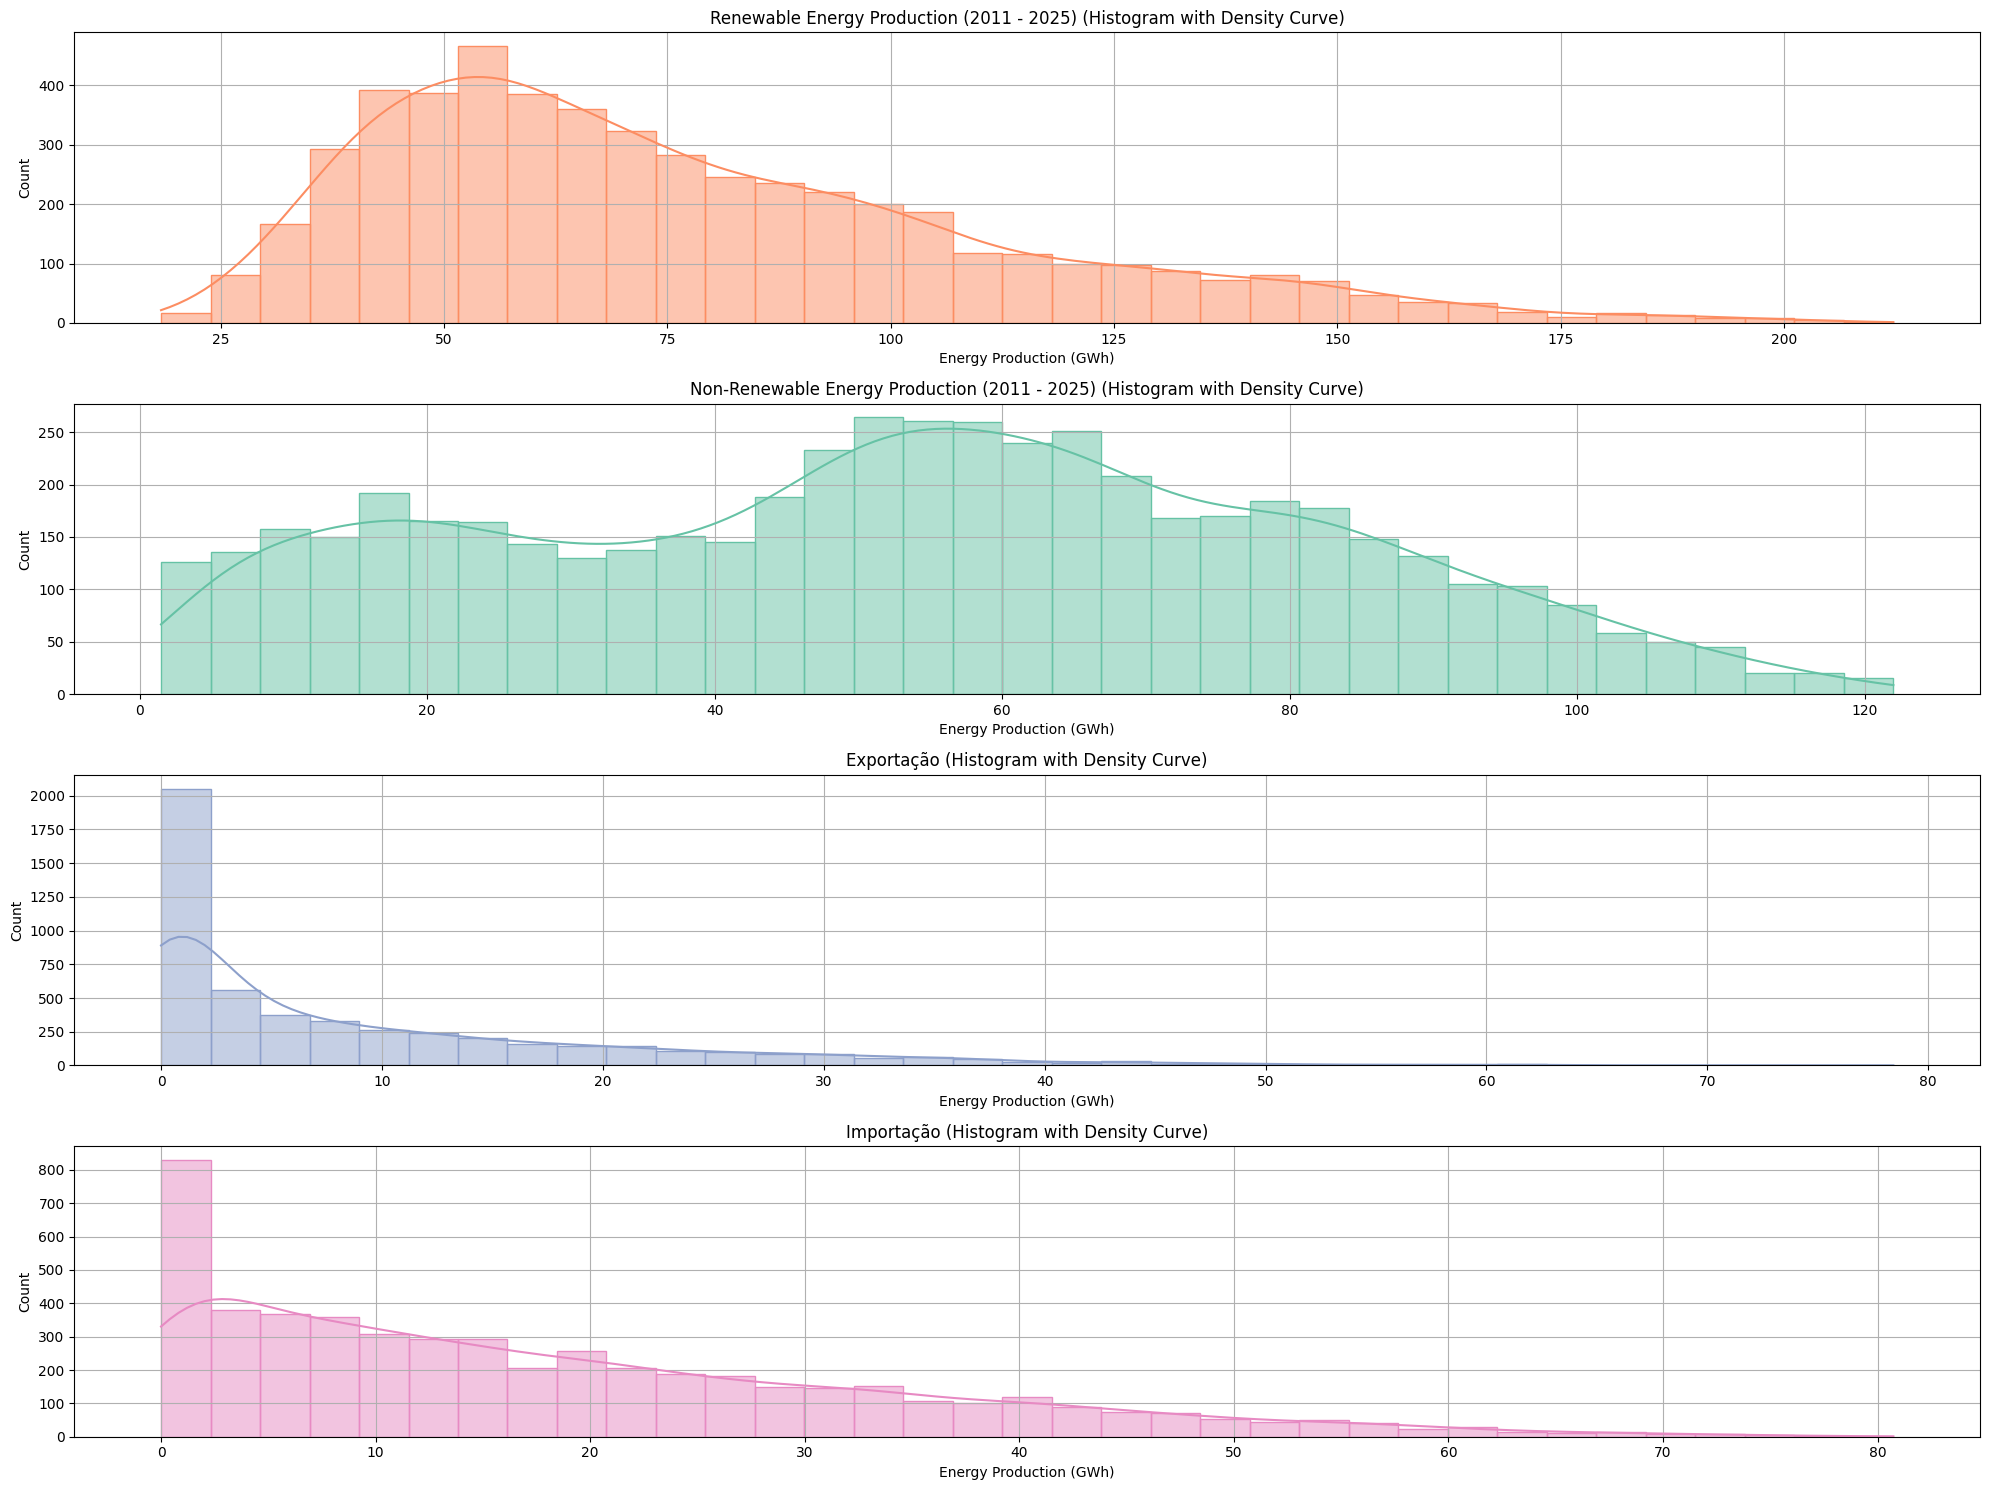

In [133]:
fig, axes = plt.subplots(4, 1, figsize=(20, 15))

# Data for histograms
histogram_data = [
    ('producao_renovavel', title_renewable, color_renewable),
    ('producao_nao_renovavel', title_non_renewable, color_non_renewable),
    ('exportacao', 'Exportação', color_export),
    ('importacao', 'Importação', color_import)
]

# Loop through data to create histograms
for ax, (column, title, color) in zip(axes, histogram_data):
    sns.histplot(df[column], bins=35, color=color,
                 kde=True, edgecolor=color, ax=ax)
    ax.set_title(f'{title} (Histogram with Density Curve)')
    ax.set_xlabel(ylab)
    ax.grid(True)

plt.tight_layout()
plt.show()

### Função de distribuição acumulativa

In [134]:
df_non_renewable = df['producao_nao_renovavel'].to_frame()
df_renewable = df['producao_renovavel'].to_frame()
df_export = df['exportacao'].to_frame()
df_import = df['importacao'].to_frame()

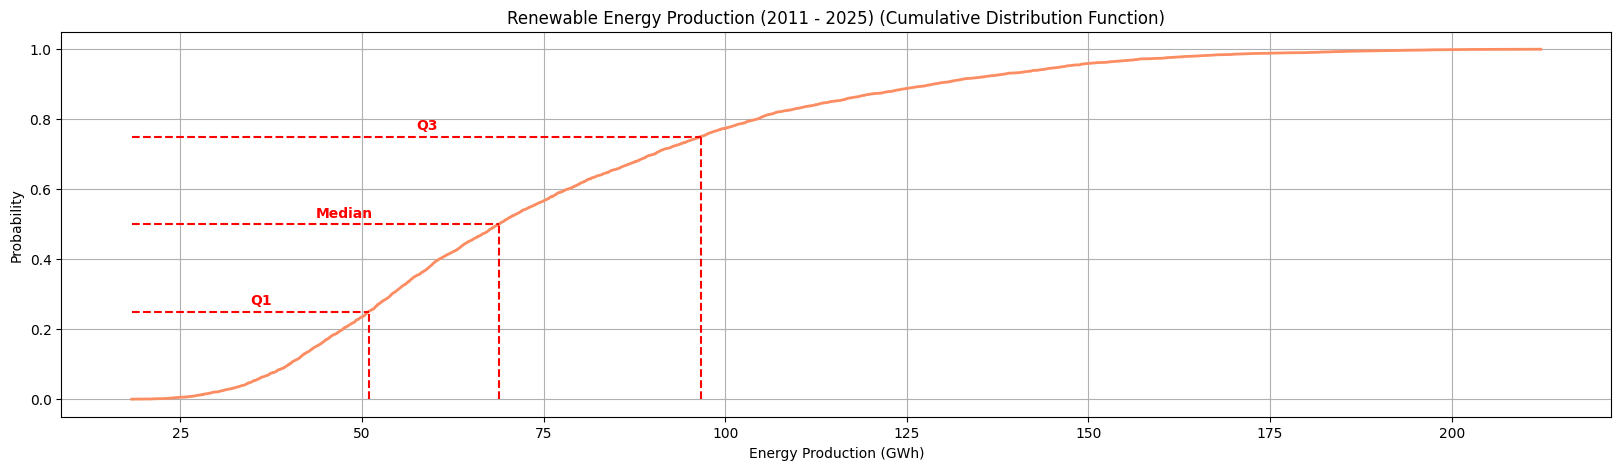

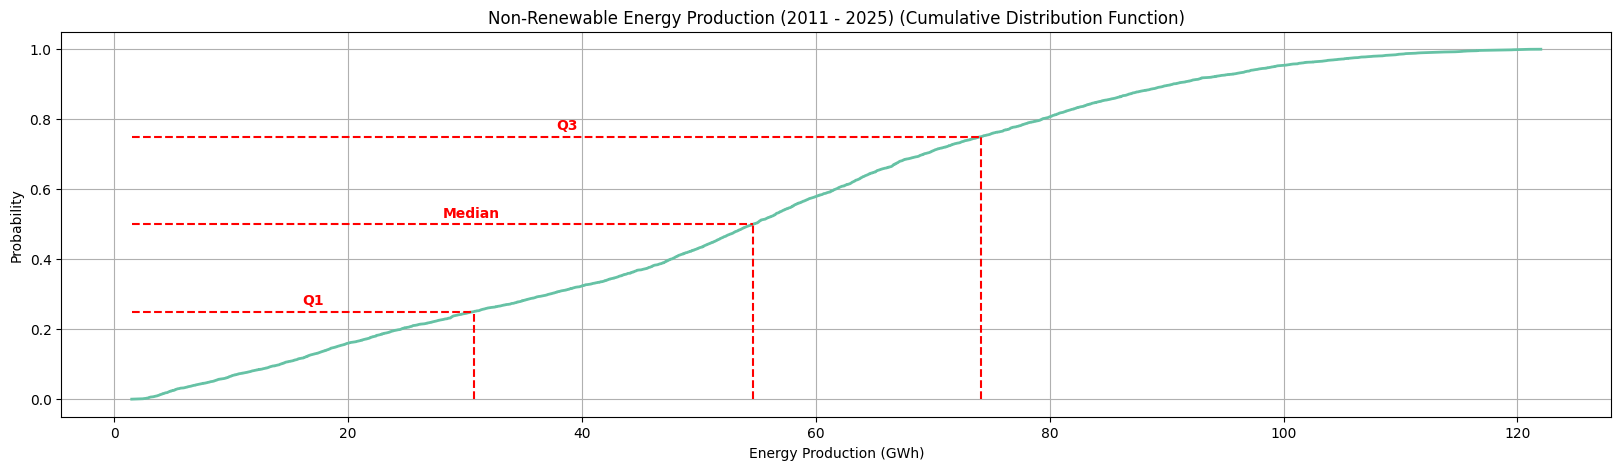

In [147]:
def plot_cdf(data, title, color, y_label, x_label):
    """
    Plots the Cumulative Distribution Function (CDF) for the given data.

    Parameters:
    - data: pandas.DataFrame or pandas.Series
        The data for which the CDF is to be plotted.
    - title: str
        The title of the plot.
    - color: str or tuple
        The color of the plot line.
    - y_label: str
        The label for the y-axis.
    - x_label: str
        The label for the x-axis.
    """
    cdf = data.sum(axis=1).value_counts().sort_index().div(len(data)).cumsum()

    plt.figure(figsize=(20, 5))
    cdf.plot(linewidth=2, color=color)
    plt.title(title + ' (Cumulative Distribution Function)')
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    min_val = data.values.min()
    q25 = np.quantile(data.values, .25)
    median_val = np.quantile(data.values, .5)
    q75 = np.quantile(data.values, .75)

    data_lines = [
        (min_val, q25), (.25, .25), 'r', (q25, q25), (0, .25), 'r',
        (min_val, median_val), (.5, .5), 'r', (median_val, median_val), (0, .5), 'r',
        (min_val, q75), (.75, .75), 'r', (q75, q75), (0, .75), 'r'
    ]
    plt.plot(*data_lines, ls='--')
    plt.text(min_val + (q25 - min_val) / 2, 0.27, "Q1", color='r', fontweight='bold')
    plt.text(min_val + (median_val - min_val) / 2, 0.52, "Median", color='r', fontweight='bold')
    plt.text(min_val + (q75 - min_val) / 2, 0.77, "Q3", color='r', fontweight='bold')
    plt.grid(True)
    plt.show()

# Cumulative Distribution Function for Renewable Energy Production
plot_cdf(
    data=df_renewable,
    title=title_renewable,
    color=color_renewable,
    y_label='Probability',
    x_label=ylab
)

# Cumulative Distribution Function for Non-Renewable Energy Production
plot_cdf(
    data=df_non_renewable,
    title=title_non_renewable,
    color=color_non_renewable,
    y_label='Probability',
    x_label=ylab
)


### Distribuição de valores por Ano

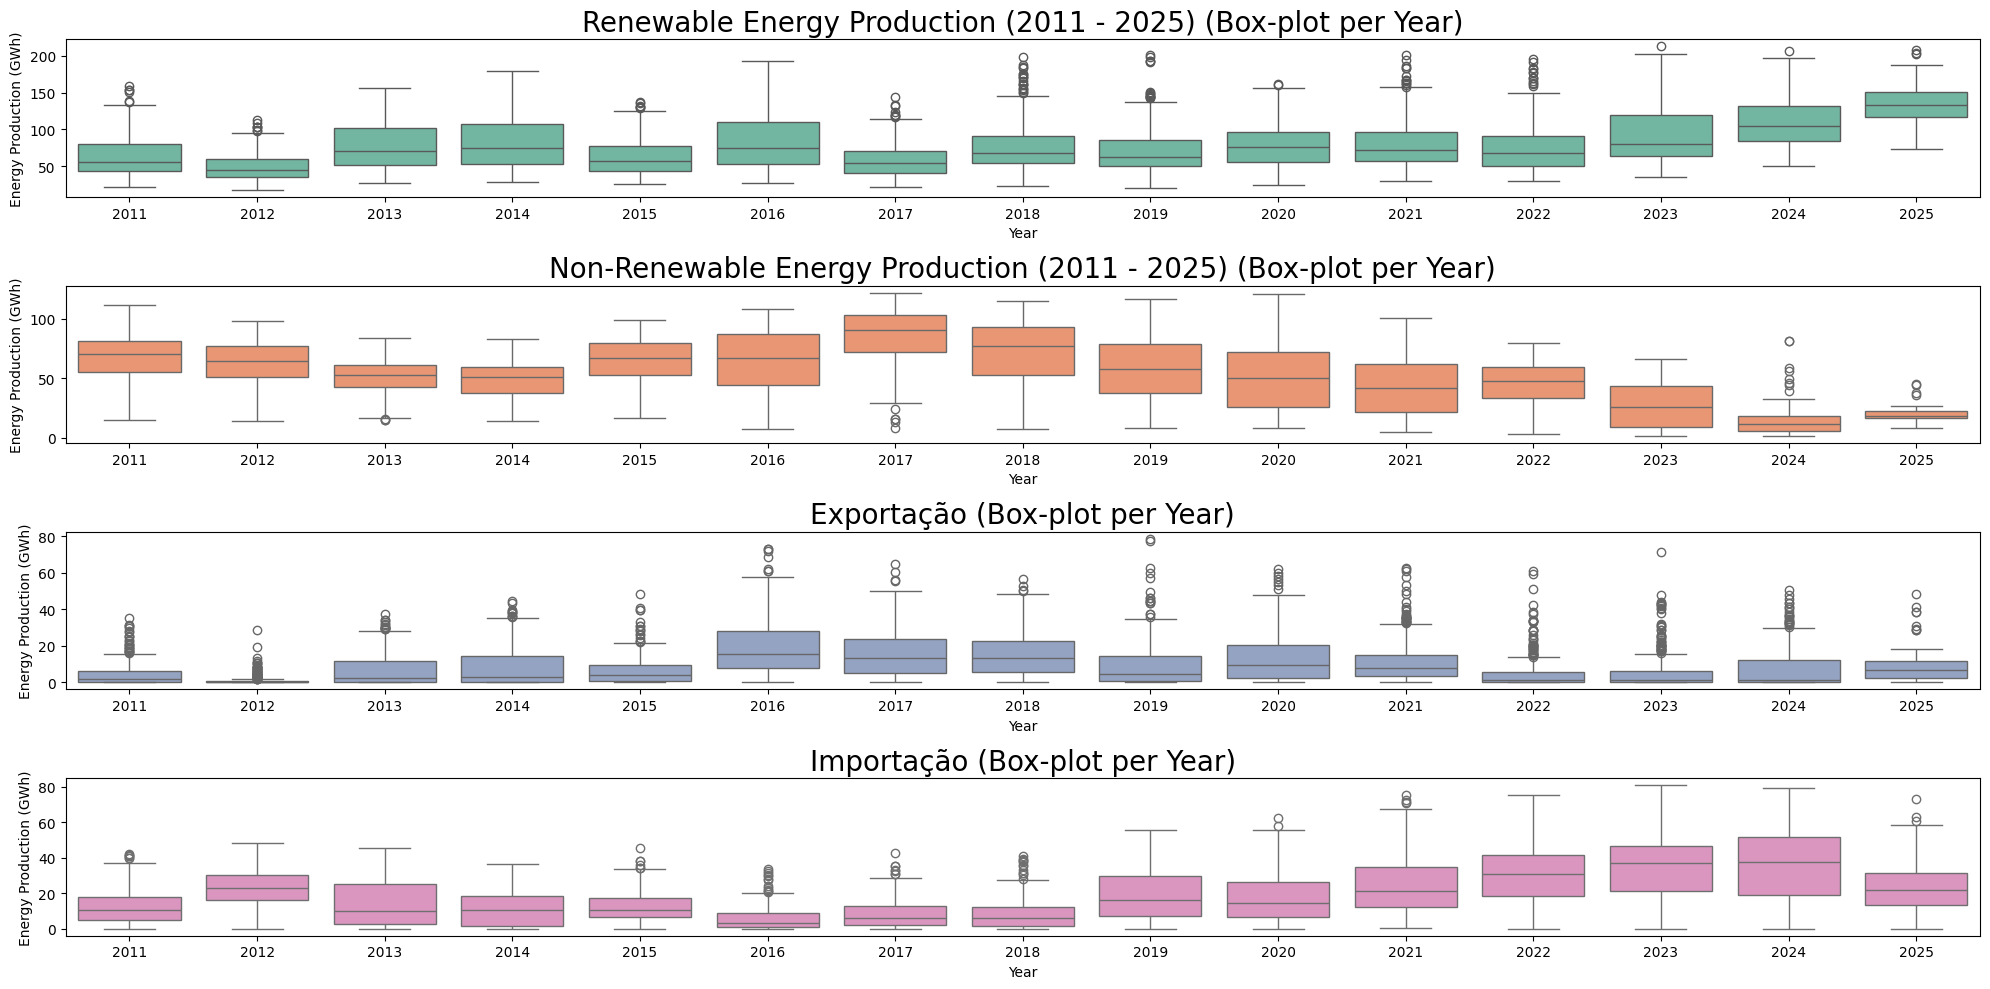

In [136]:
plt.figure(figsize=(20, 10))

# Define a list of data and titles for the box plots with improved color scheme
boxplot_data = [
    (df_renewable, 'producao_renovavel', colors[0], title_renewable),
    (df_non_renewable, 'producao_nao_renovavel',
     colors[1], title_non_renewable),
    (df_export, 'exportacao', colors[2], 'Exportação'),
    (df_import, 'importacao', colors[3], 'Importação')
]

# Loop through the data to create subplots
for i, (data, column, color, title) in enumerate(boxplot_data, start=1):
    plt.subplot(4, 1, i)
    box_plot = sns.boxplot(x=df.index.year, y=column, data=data, color=color)
    box_plot.set_xlabel('Year')
    box_plot.set_ylabel(ylab)
    box_plot.set_title(f'{title} (Box-plot per Year)', fontsize=20)

plt.tight_layout()
plt.show()

### Análise das componentes das series

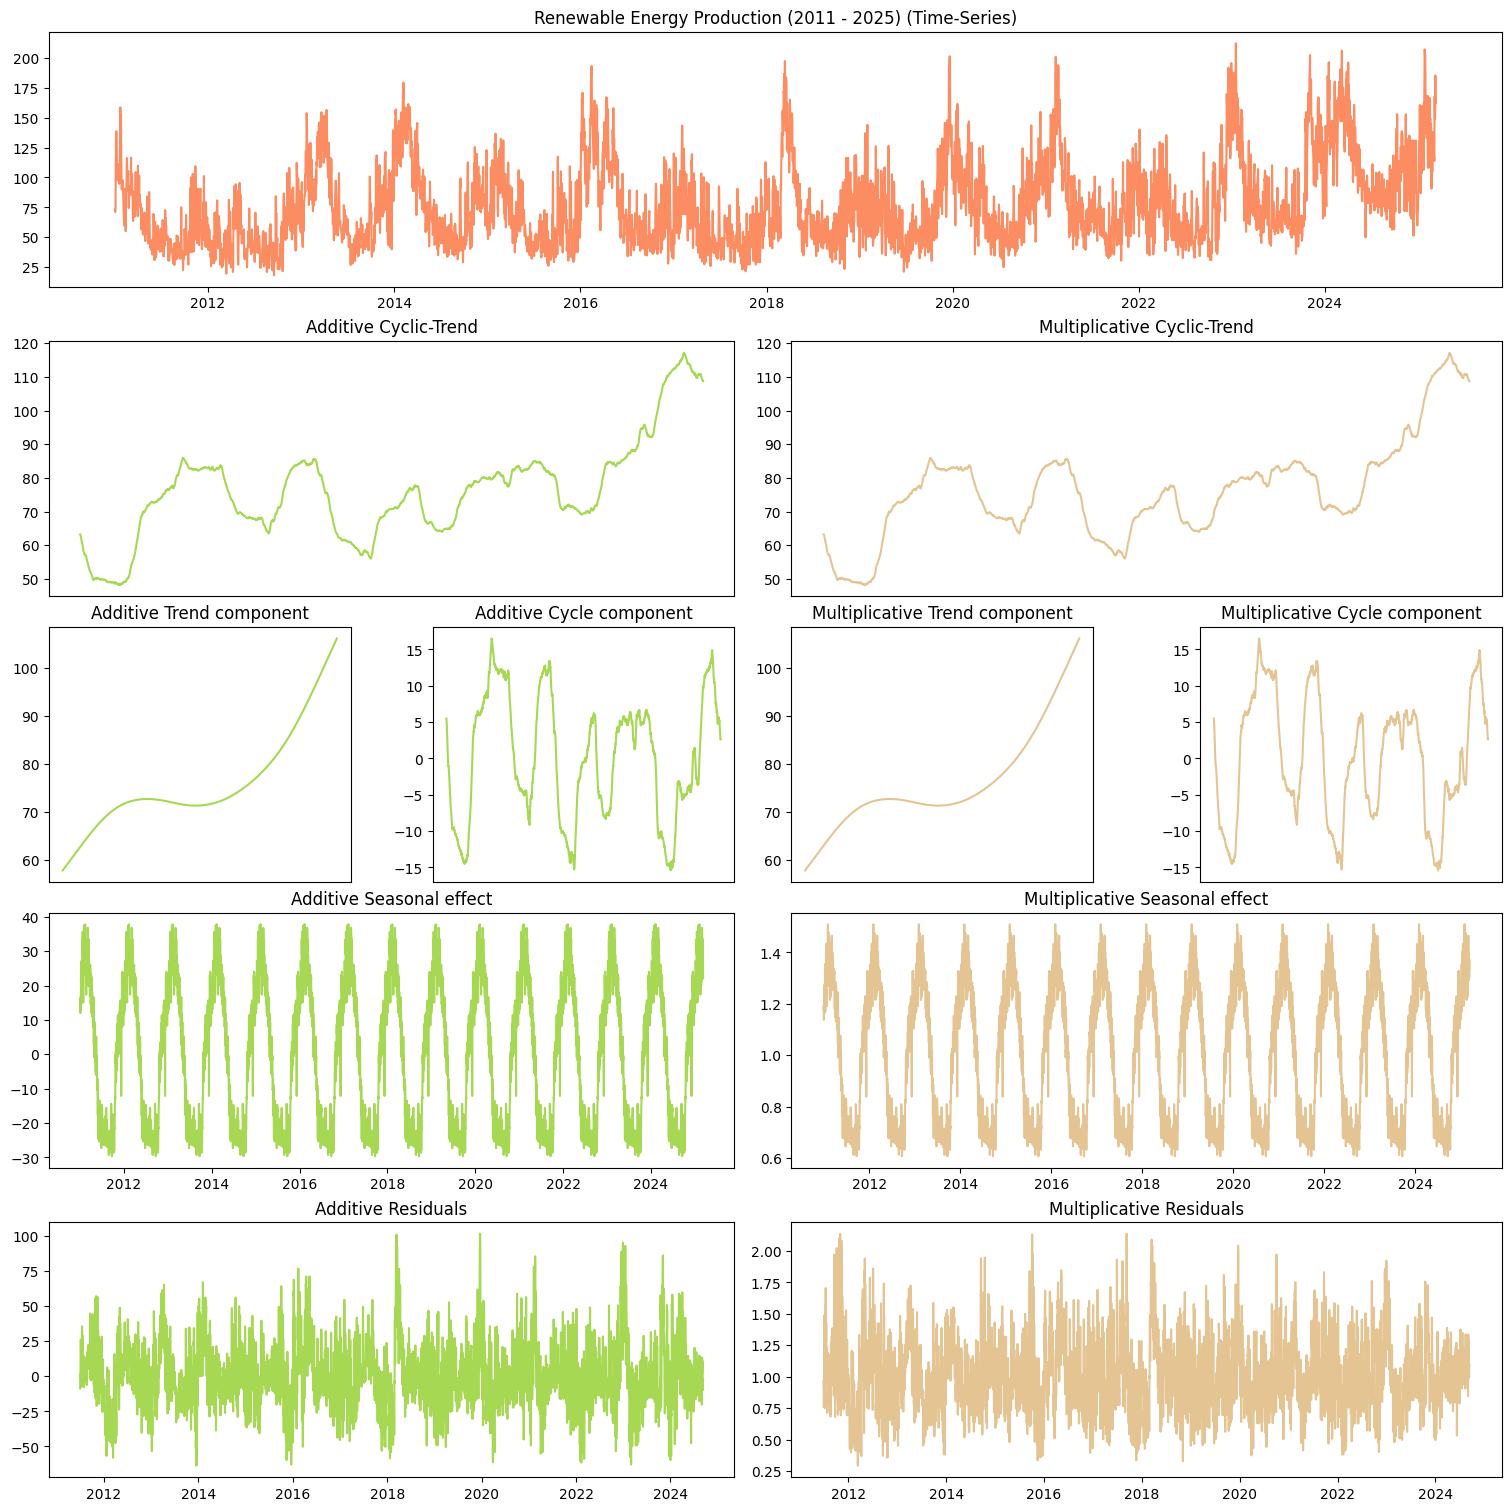

In [137]:
resultAdd = seasonal_decompose(df_renewable, model='additive', period=seasonal_periods)
resultMul = seasonal_decompose(df_renewable, model='multiplicative', period=seasonal_periods)

# Hodrick-Prescott filter
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend.dropna(), lamb=lamb)
cycleMul, trendMul = sm.tsa.filters.hpfilter(resultMul.trend.dropna(), lamb=lamb)

fig = plt.figure(figsize=(15, 15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)

# Plot original time series
fig.add_subplot(spec[0, :])
plt.plot(df_renewable, color=color_renewable)
plt.title(title_renewable + ' (Time-Series)')

# Additive and Multiplicative components
components = [
    (resultAdd.trend, 'Additive Cyclic-Trend', spec[1, :2]),
    (trendAdd, 'Additive Trend component', spec[2, 0]),
    (cycleAdd, 'Additive Cycle component', spec[2, 1]),
    (resultAdd.seasonal, 'Additive Seasonal effect', spec[3, :2]),
    (resultAdd.resid, 'Additive Residuals', spec[4, :2]),
    (resultMul.trend, 'Multiplicative Cyclic-Trend', spec[1, 2:]),
    (trendMul, 'Multiplicative Trend component', spec[2, 2]),
    (cycleMul, 'Multiplicative Cycle component', spec[2, 3]),
    (resultMul.seasonal, 'Multiplicative Seasonal effect', spec[3, 2:]),
    (resultMul.resid, 'Multiplicative Residuals', spec[4, 2:])
]

for data, title, position in components:
    ax = fig.add_subplot(position)
    ax.plot(data, color=colors[4] if 'Additive' in title else colors[6])
    ax.set_title(title)
    if 'Trend' in title or 'Cycle' in title:
        ax.set_xticks([])

plt.show()


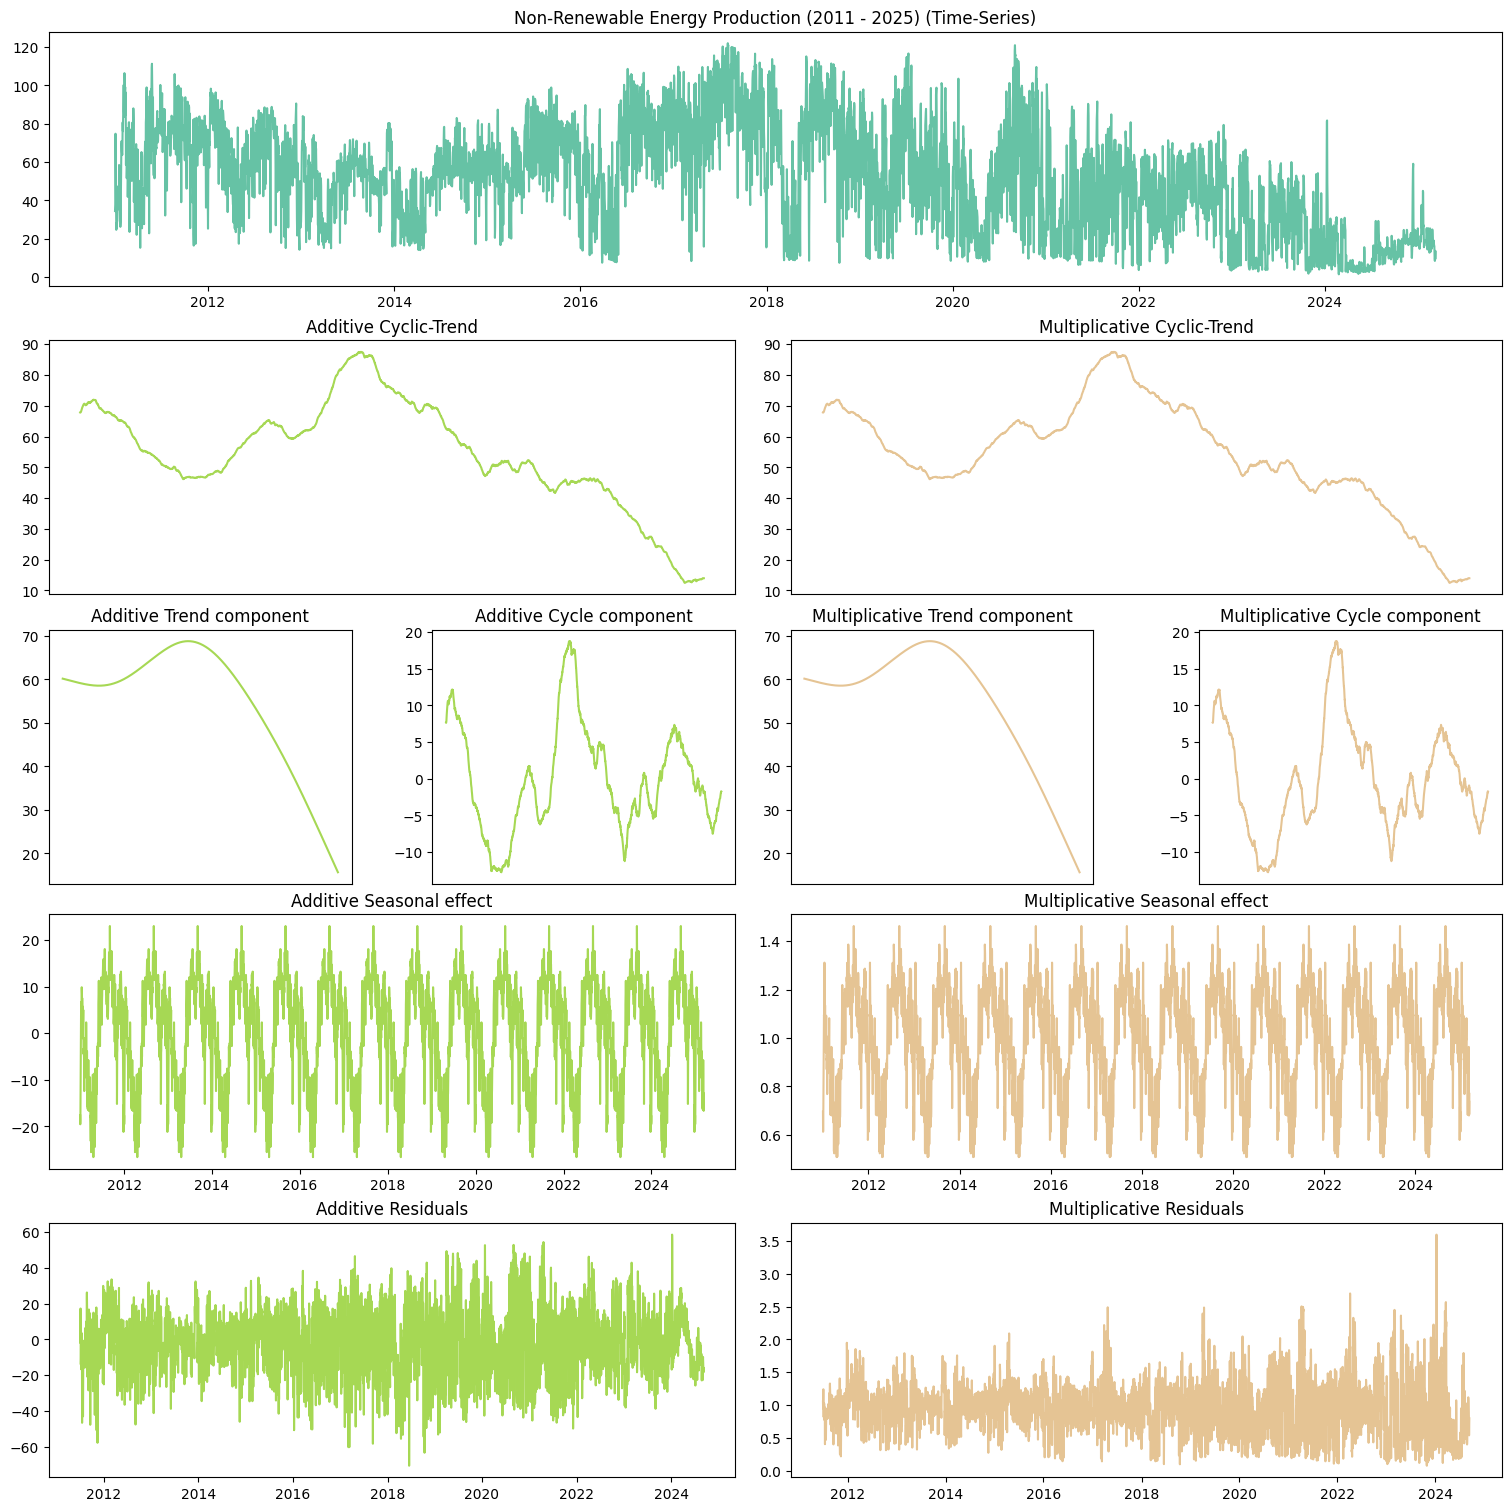

In [138]:
resultAdd = seasonal_decompose(df_non_renewable, model='additive', period=seasonal_periods)
resultMul = seasonal_decompose(df_non_renewable, model='multiplicative', period=seasonal_periods)

# Hodrick-Prescott filter
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend.dropna(), lamb=lamb)
cycleMul, trendMul = sm.tsa.filters.hpfilter(resultMul.trend.dropna(), lamb=lamb)

fig = plt.figure(figsize=(15, 15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)

# Plot original time series
fig.add_subplot(spec[0, :])
plt.plot(df_non_renewable, color=color_non_renewable)
plt.title(title_non_renewable + ' (Time-Series)')

# Additive and Multiplicative components
components = [
    (resultAdd.trend, 'Additive Cyclic-Trend', spec[1, :2]),
    (trendAdd, 'Additive Trend component', spec[2, 0]),
    (cycleAdd, 'Additive Cycle component', spec[2, 1]),
    (resultAdd.seasonal, 'Additive Seasonal effect', spec[3, :2]),
    (resultAdd.resid, 'Additive Residuals', spec[4, :2]),
    (resultMul.trend, 'Multiplicative Cyclic-Trend', spec[1, 2:]),
    (trendMul, 'Multiplicative Trend component', spec[2, 2]),
    (cycleMul, 'Multiplicative Cycle component', spec[2, 3]),
    (resultMul.seasonal, 'Multiplicative Seasonal effect', spec[3, 2:]),
    (resultMul.resid, 'Multiplicative Residuals', spec[4, 2:])
]

for data, title, position in components:
    ax = fig.add_subplot(position)
    ax.plot(data, color=colors[4] if 'Additive' in title else colors[6])
    ax.set_title(title)
    if 'Trend' in title or 'Cycle' in title:
        ax.set_xticks([])

plt.show()

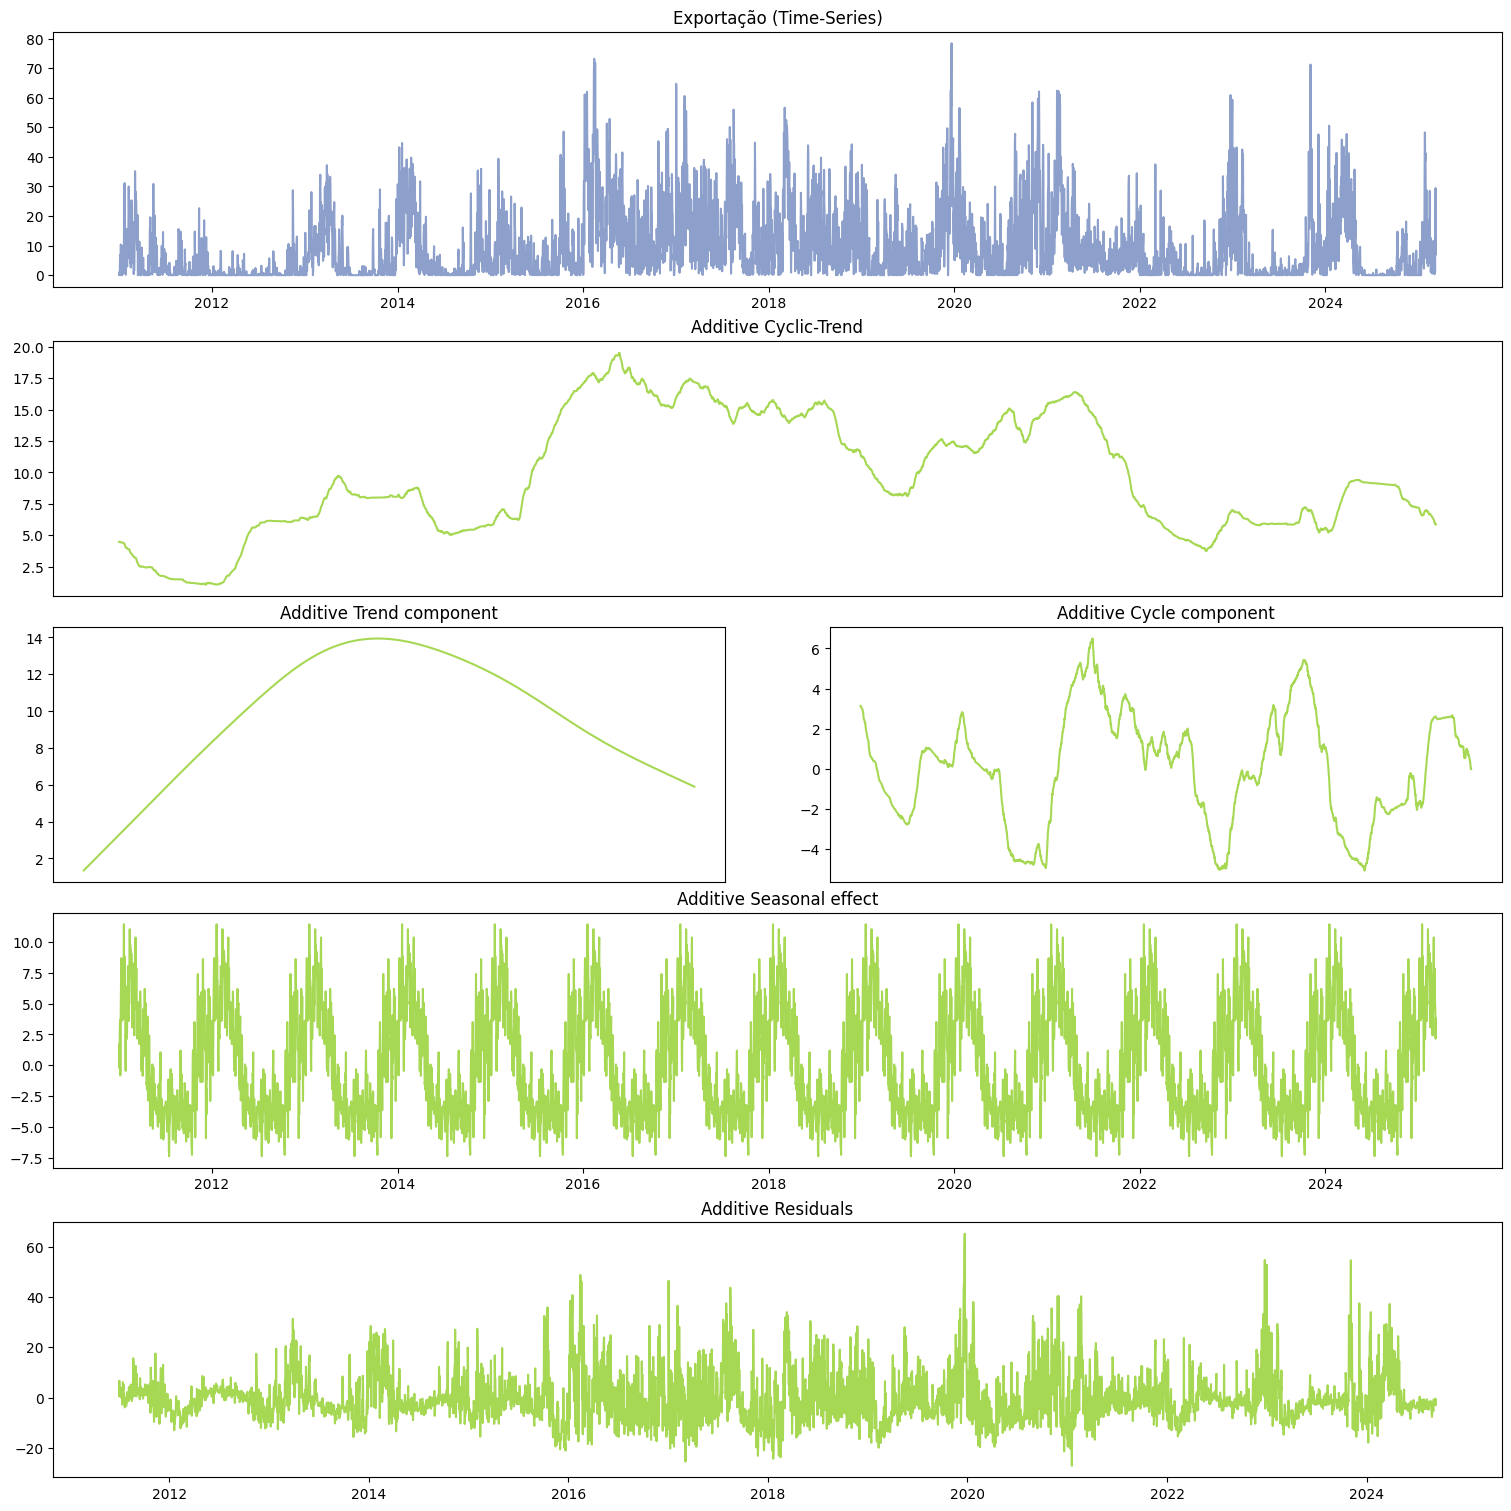

In [139]:
resultAdd = seasonal_decompose(df_export, model='additive', period=seasonal_periods)

# Hodrick-Prescott filter
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend.dropna(), lamb=lamb)

fig = plt.figure(figsize=(15, 15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=5, figure=fig)

# Plot original time series
fig.add_subplot(spec[0, :])
plt.plot(df_export, color=color_export)
plt.title('Exportação (Time-Series)')

# Additive components
components = [
    (resultAdd.trend, 'Additive Cyclic-Trend', spec[1, :2]),
    (trendAdd, 'Additive Trend component', spec[2, 0]),
    (cycleAdd, 'Additive Cycle component', spec[2, 1]),
    (resultAdd.seasonal, 'Additive Seasonal effect', spec[3, :2]),
    (resultAdd.resid, 'Additive Residuals', spec[4, :2])
]

for data, title, position in components:
    ax = fig.add_subplot(position)
    ax.plot(data, color=colors[4])
    ax.set_title(title)
    if 'Trend' in title or 'Cycle' in title:
        ax.set_xticks([])

plt.show()


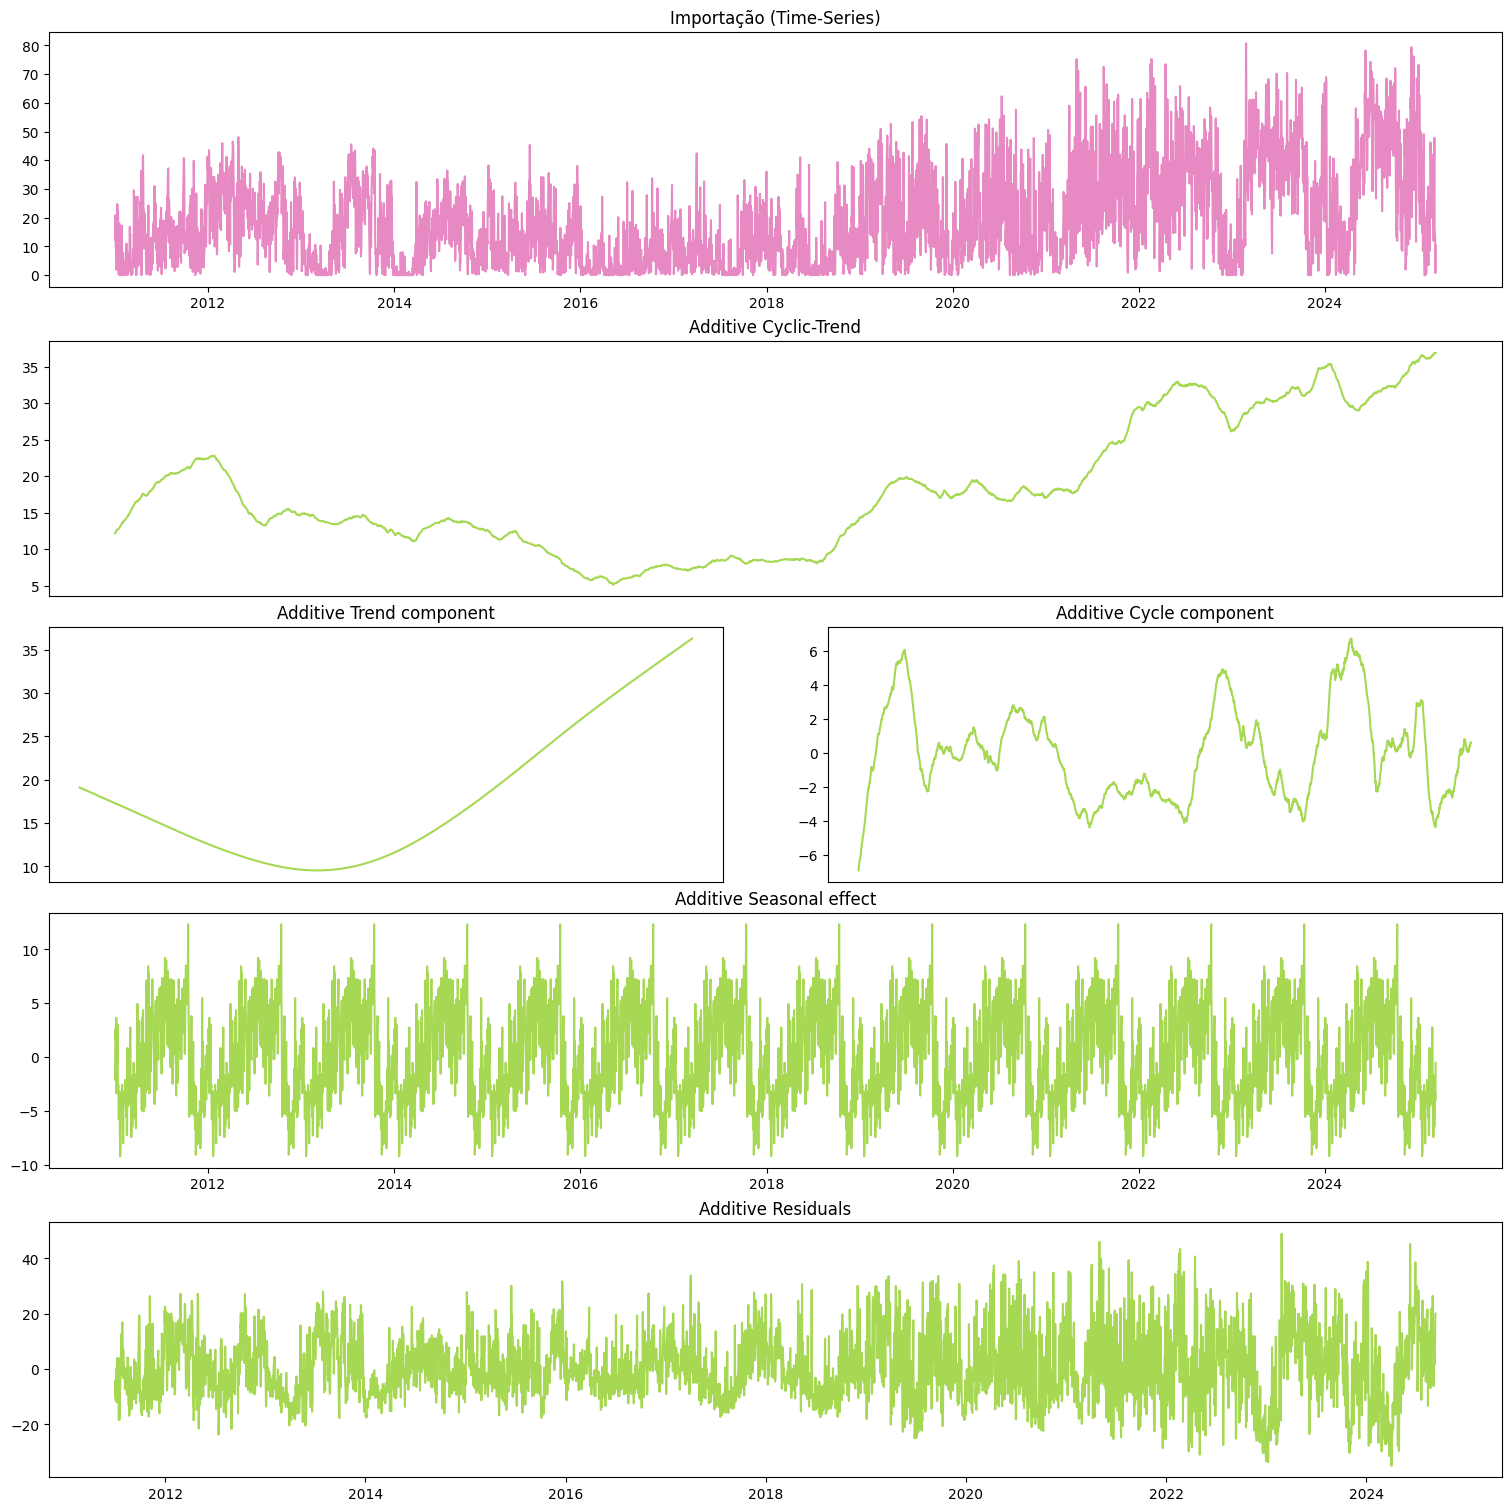

In [140]:
resultAdd = seasonal_decompose(df_import, model='additive', period=seasonal_periods)

# Hodrick-Prescott filter
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend.dropna(), lamb=lamb)

fig = plt.figure(figsize=(15, 15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=5, figure=fig)

# Plot original time series
fig.add_subplot(spec[0, :])
plt.plot(df_import, color=color_import)
plt.title('Importação (Time-Series)')

# Additive components
components = [
    (resultAdd.trend, 'Additive Cyclic-Trend', spec[1, :2]),
    (trendAdd, 'Additive Trend component', spec[2, 0]),
    (cycleAdd, 'Additive Cycle component', spec[2, 1]),
    (resultAdd.seasonal, 'Additive Seasonal effect', spec[3, :2]),
    (resultAdd.resid, 'Additive Residuals', spec[4, :2])
]

for data, title, position in components:
    ax = fig.add_subplot(position)
    ax.plot(data, color=colors[4])
    ax.set_title(title)
    if 'Trend' in title or 'Cycle' in title:
        ax.set_xticks([])

plt.show()


In [ ]:
def calculate_strengths(data, model, period=seasonal_periods):
    """Calculate trend and seasonality strength for a time series."""
    decomposition = seasonal_decompose(data, model=model, period=period)
    residuals = decomposition.resid.dropna()
    trend = decomposition.trend.dropna()
    original = data.loc[trend.index]

    var_original = original.var()
    var_residuals = residuals.var()
    var_trend = trend.var()

    trend_strength = 1 - (var_residuals / var_original)
    seasonality_strength = 1 - (var_residuals / (var_original - var_trend))

    return trend_strength, seasonality_strength

# Calculate strengths for each series
strengths_renewable = calculate_strengths(df_renewable['producao_renovavel'], 'additive')
strengths_non_renewable = calculate_strengths(df_non_renewable['producao_nao_renovavel'], 'additive')
strengths_export = calculate_strengths(df_export['exportacao'], 'additive')
strengths_import = calculate_strengths(df_import['importacao'], 'additive')

# Print results
print(f"Renewable Energy - Trend Strength: {strengths_renewable[0]:.4f}, Seasonality Strength: {strengths_renewable[1]:.4f}")
print(f"Non-Renewable Energy - Trend Strength: {strengths_non_renewable[0]:.4f}, Seasonality Strength: {strengths_non_renewable[1]:.4f}")
print(f"Energy Exportation - Trend Strength: {strengths_export[0]:.4f}, Seasonality Strength: {strengths_export[1]:.4f}")
print(f"Energy Importation - Trend Strength: {strengths_import[0]:.4f}, Seasonality Strength: {strengths_import[1]:.4f}")

Renewable Energy - Trend Strength: 0.5412, Seasonality Strength: 0.4429
Non-Renewable Energy - Trend Strength: 0.5767, Seasonality Strength: 0.3163
Energy Exportation - Trend Strength: 0.3086, Seasonality Strength: 0.1816
Energy Importation - Trend Strength: 0.4144, Seasonality Strength: 0.1631


In [143]:
strengths_renewable = calculate_strengths(df_renewable['producao_renovavel'], 'multiplicative')
strengths_non_renewable = calculate_strengths(df_non_renewable['producao_nao_renovavel'], 'multiplicative')
# strengths_export = calculate_strengths(df_export['exportacao'], 'multiplicative')
# strengths_import = calculate_strengths(df_import['importacao'], 'multiplicative')

# Print results
print(f"Renewable Energy - Trend Strength: {strengths_renewable[0]:.4f}, Seasonality Strength: {strengths_renewable[1]:.4f}")
print(f"Non-Renewable Energy - Trend Strength: {strengths_non_renewable[0]:.4f}, Seasonality Strength: {strengths_non_renewable[1]:.4f}")
# print(f"Energy Exportation - Trend Strength: {strengths_export[0]:.4f}, Seasonality Strength: {strengths_export[1]:.4f}")
# print(f"Energy Importation - Trend Strength: {strengths_import[0]:.4f}, Seasonality Strength: {strengths_import[1]:.4f}")

Renewable Energy - Trend Strength: 0.9999, Seasonality Strength: 0.9999
Non-Renewable Energy - Trend Strength: 0.9998, Seasonality Strength: 0.9997


### Autocorrelação dos dados

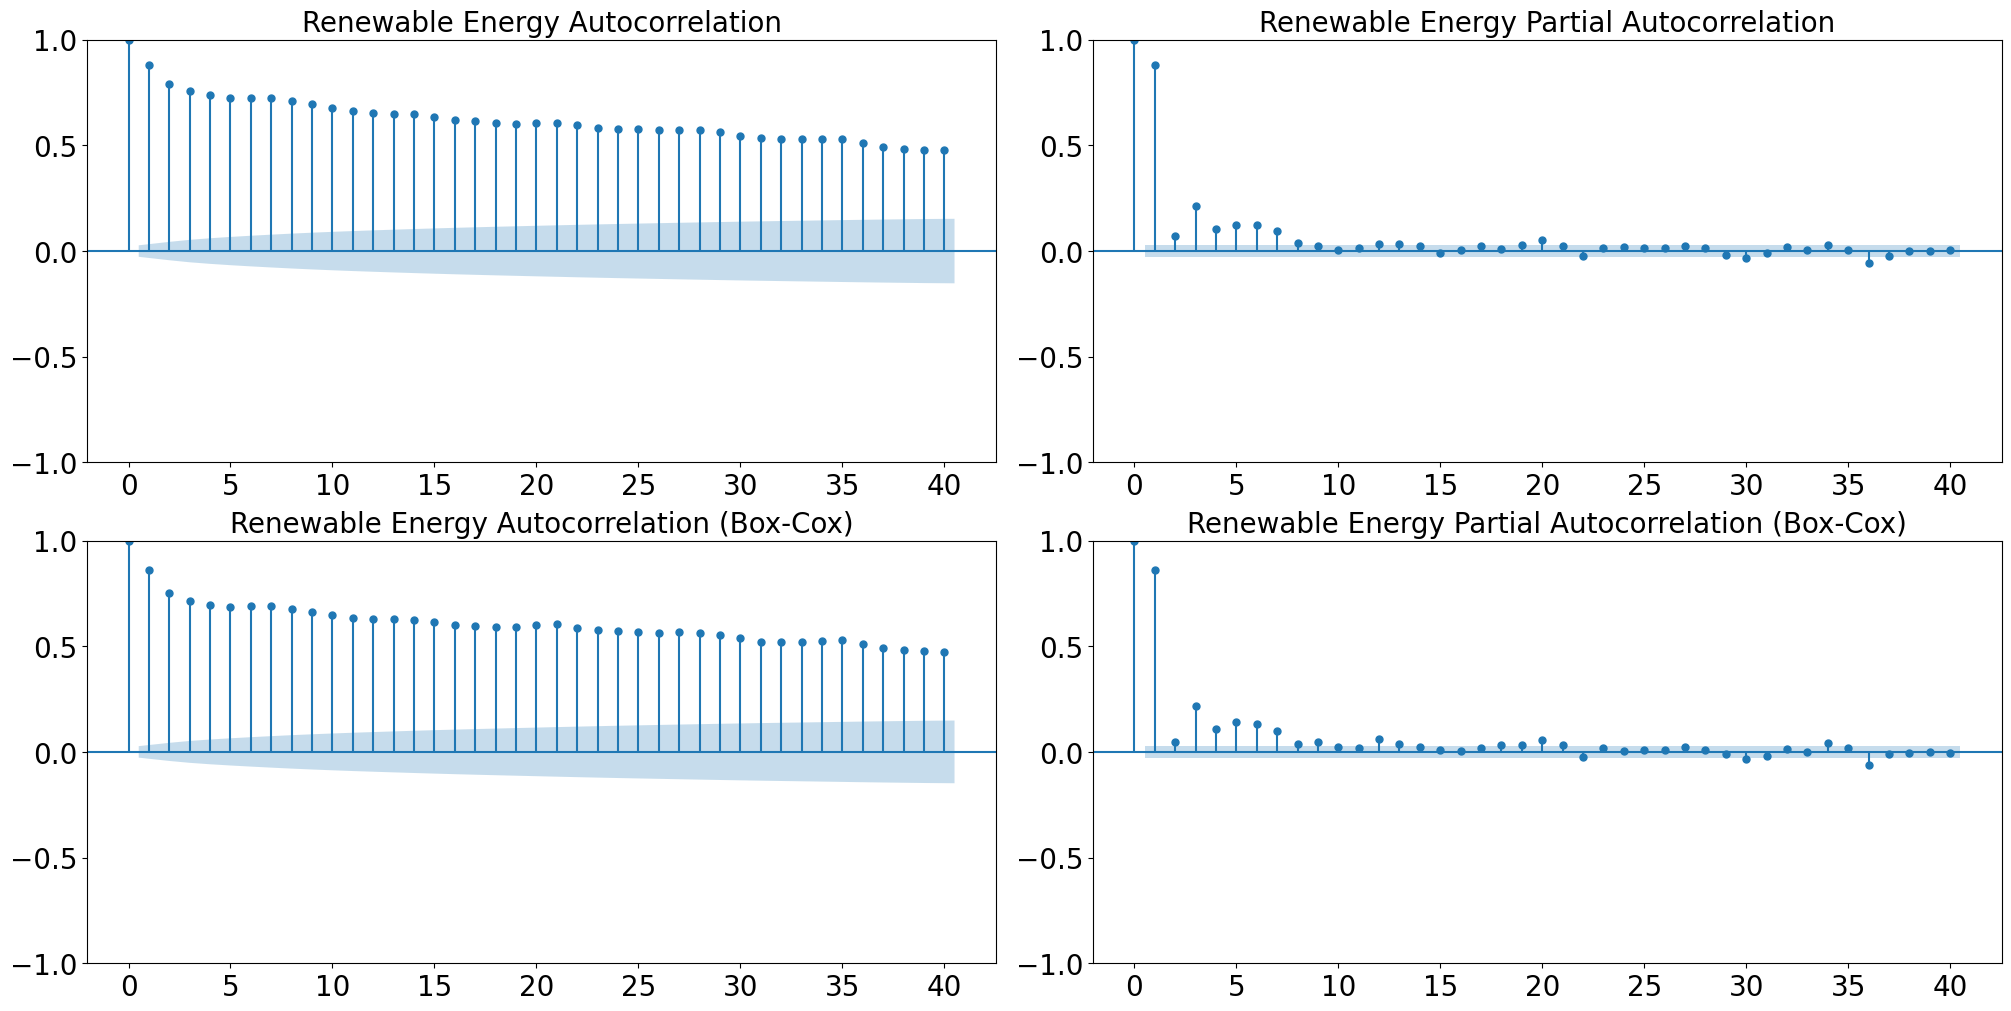

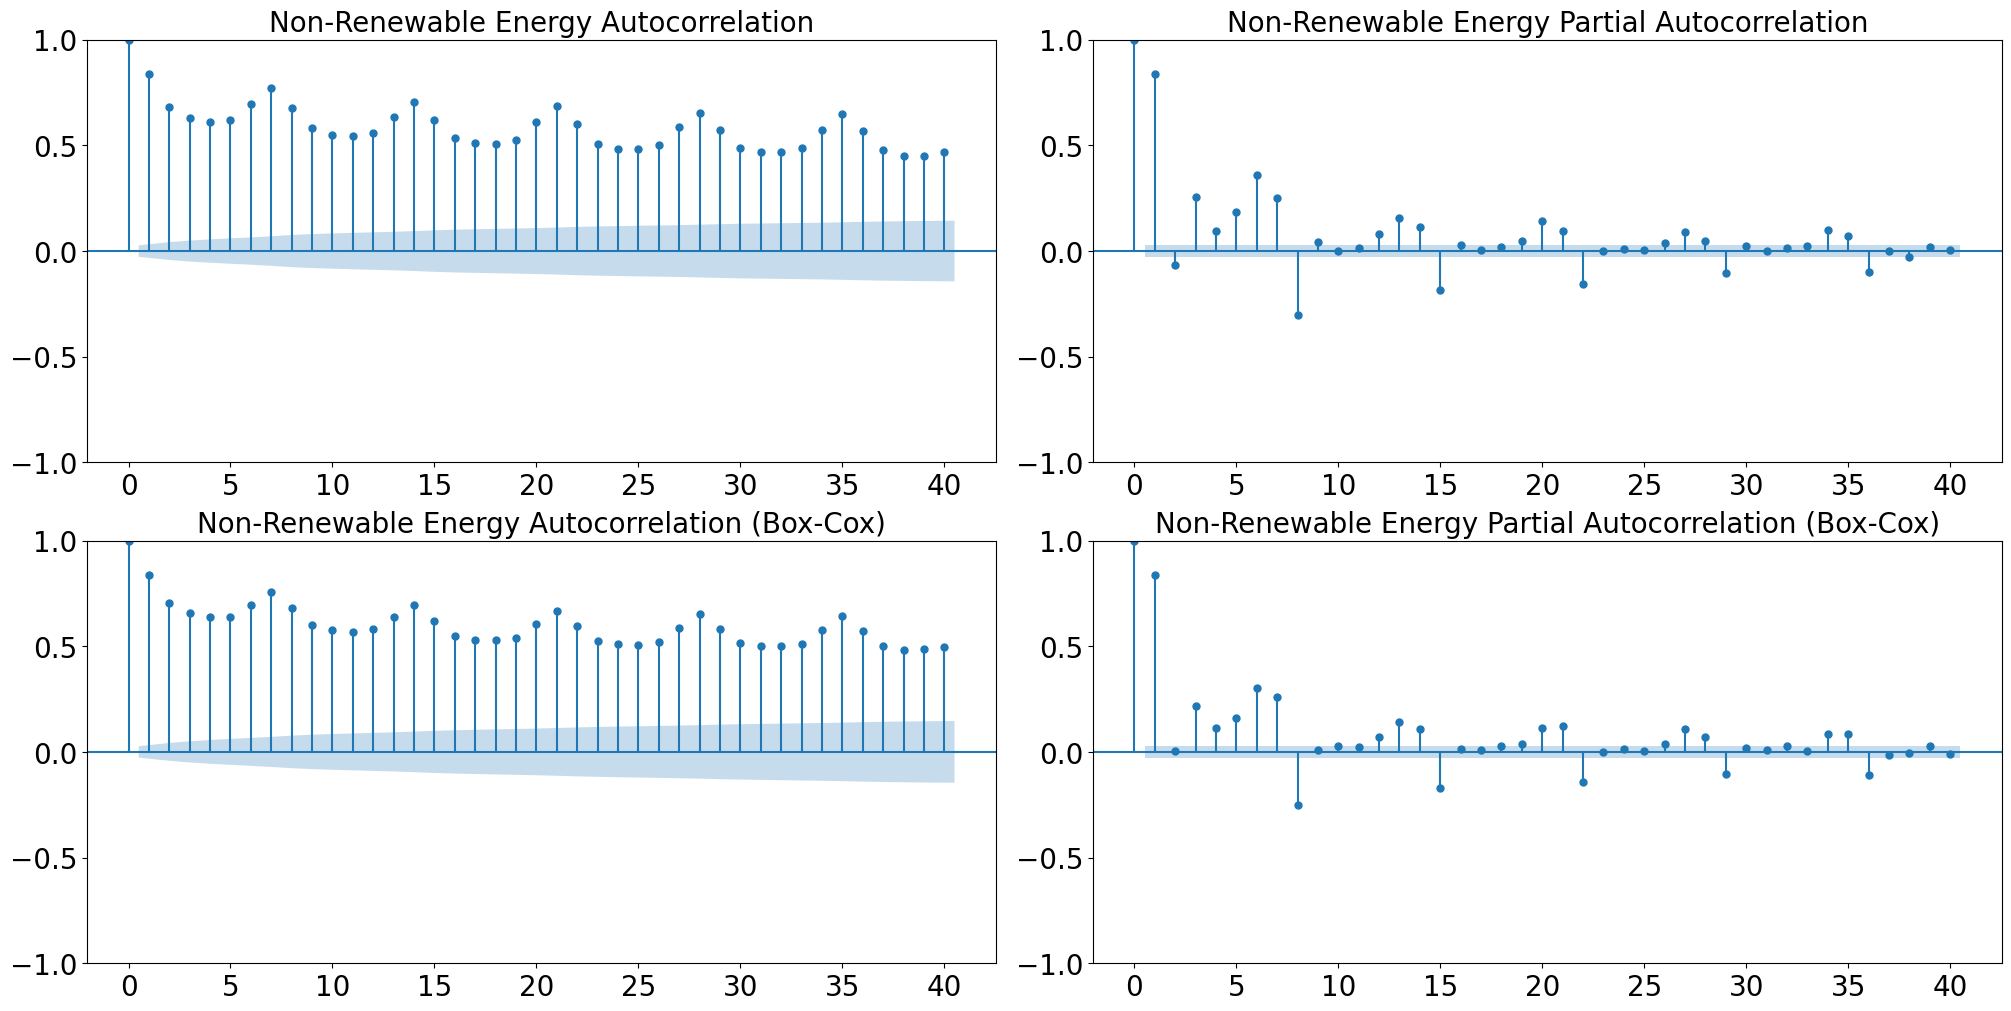

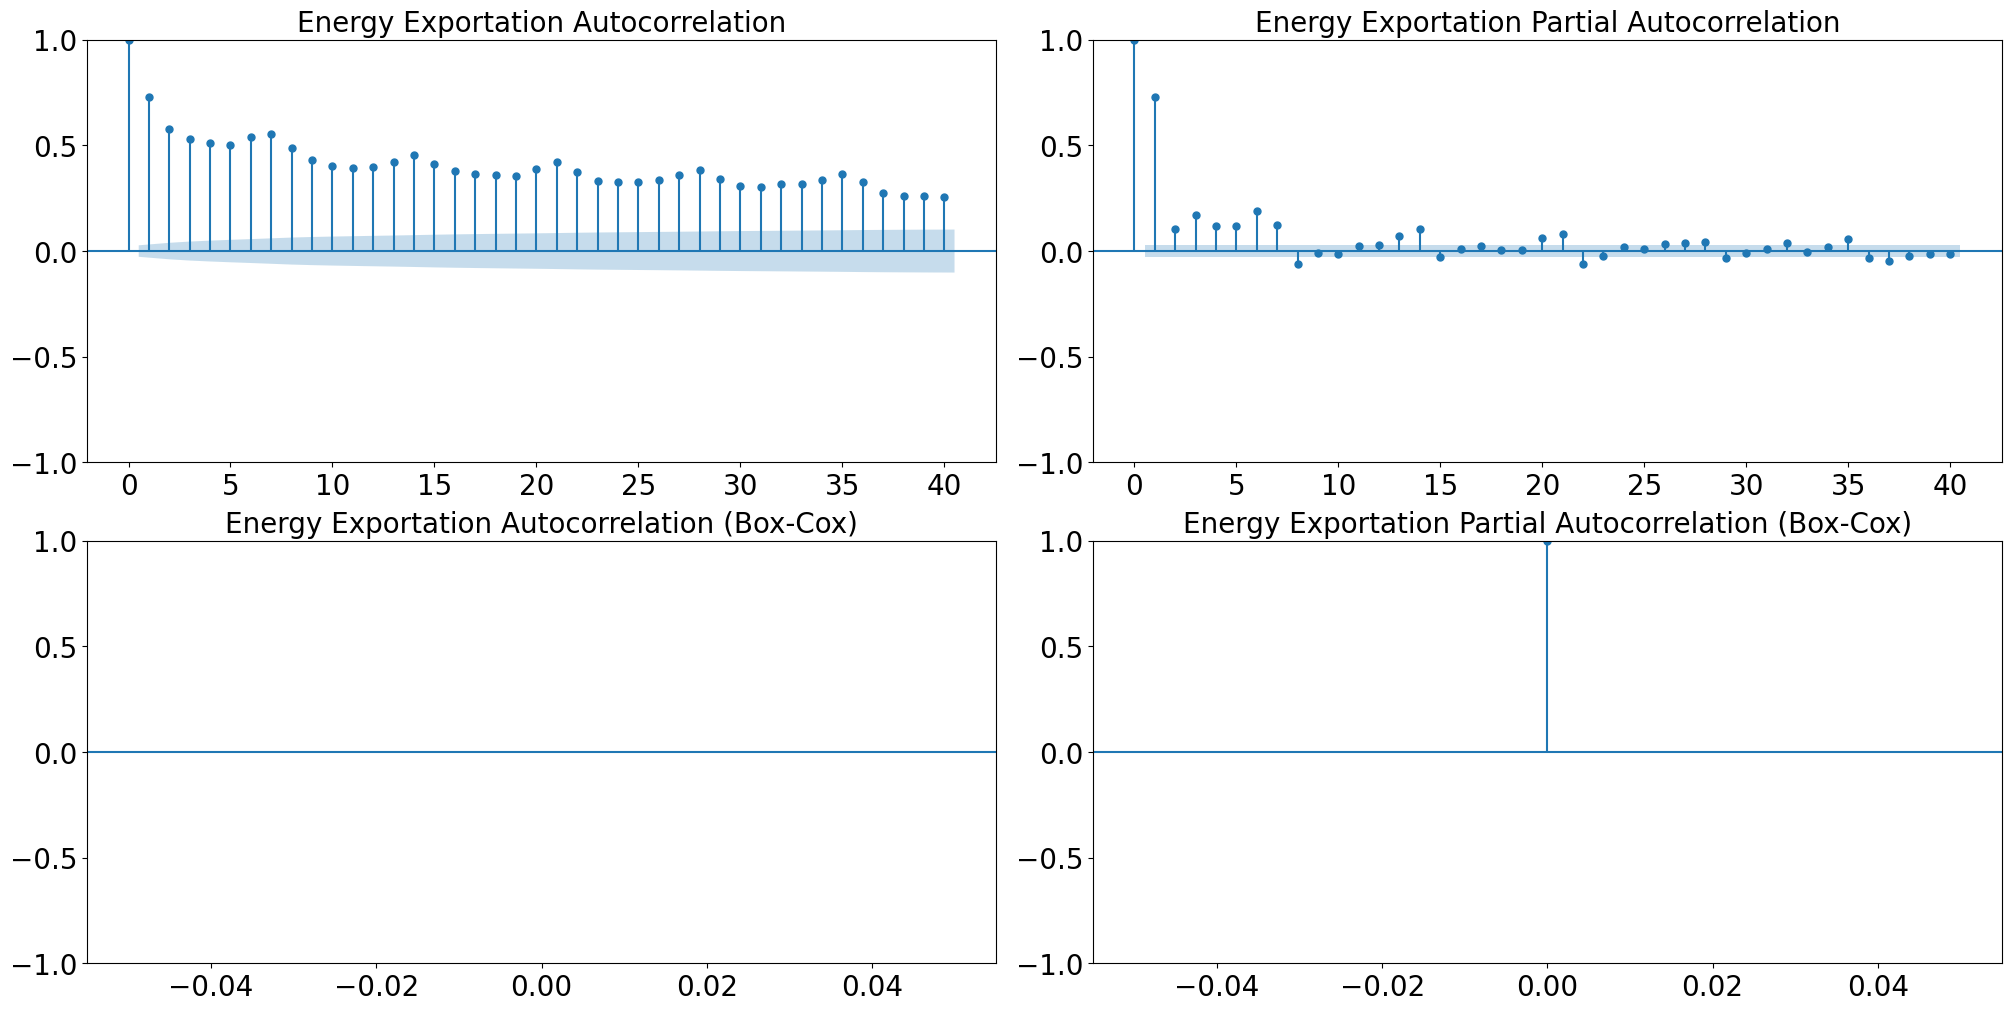

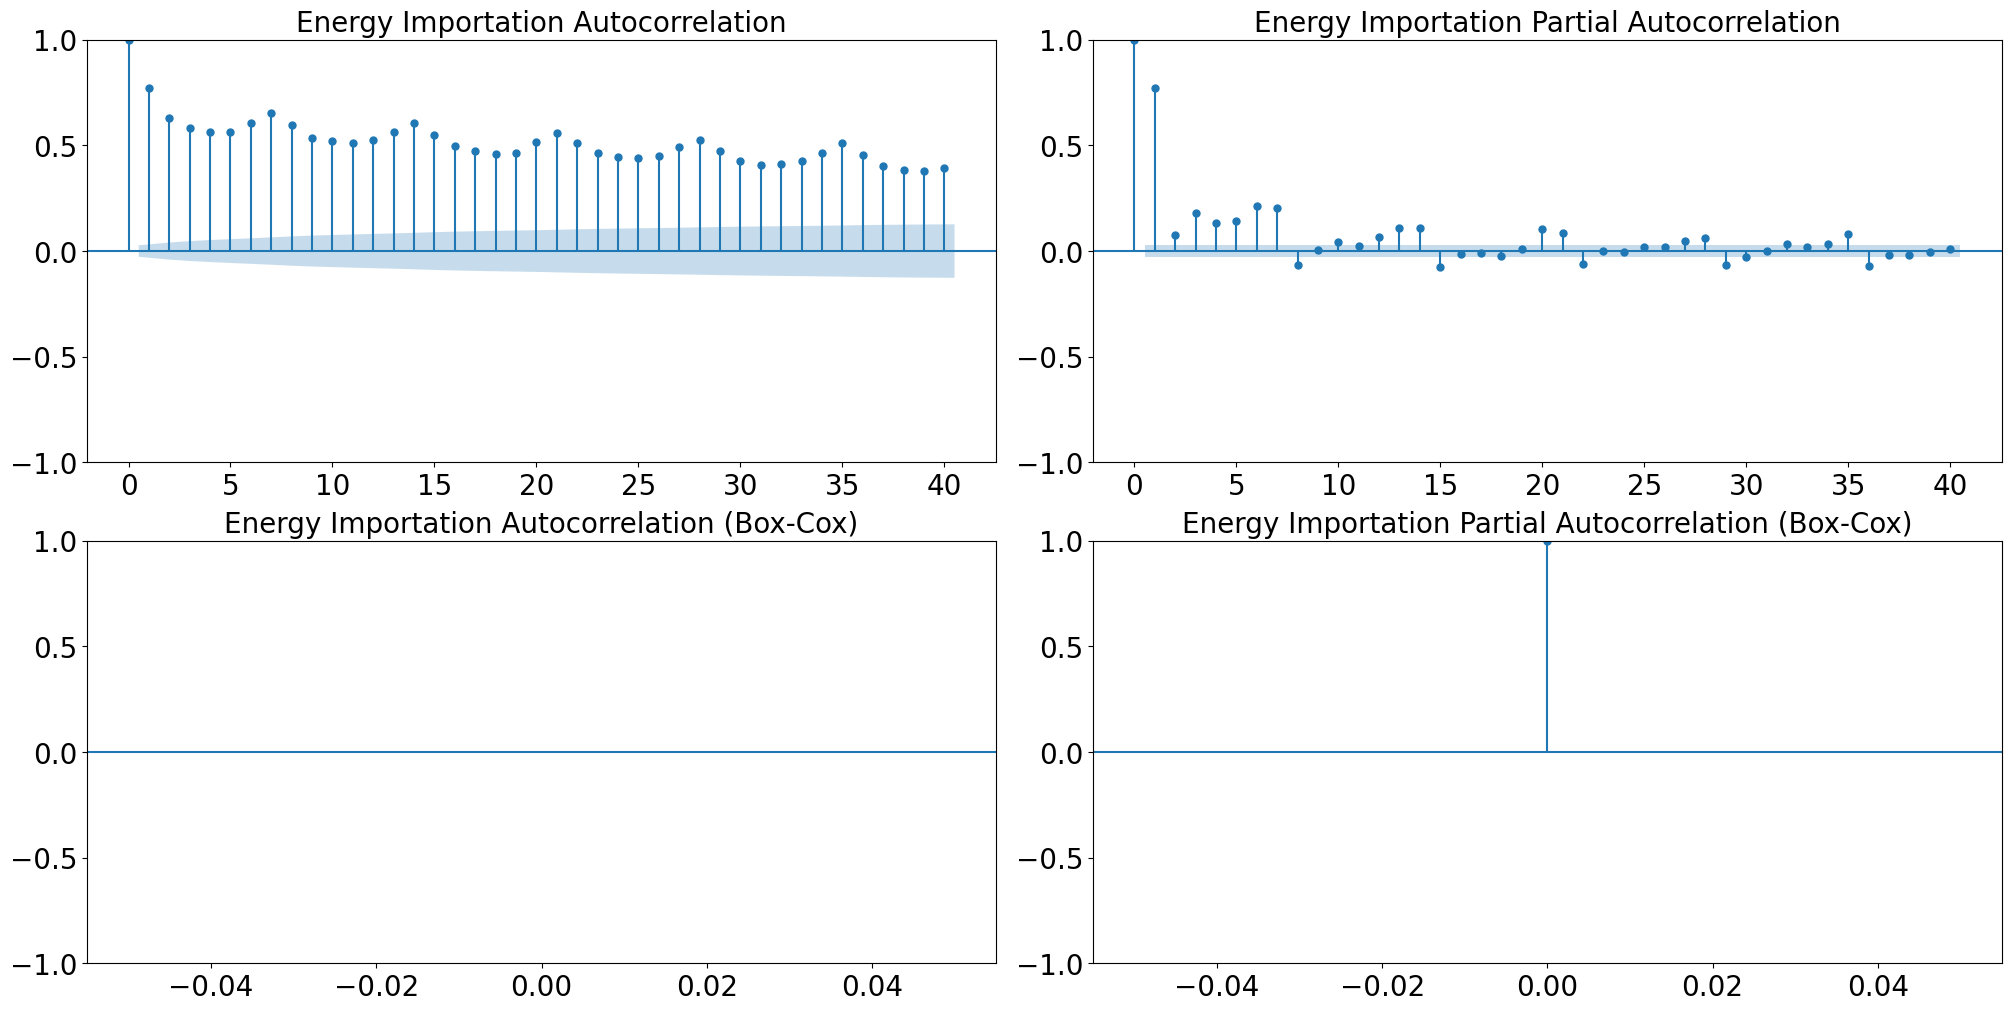

In [33]:
def plot_correlation(data, title_prefix, max_lags=40):
    """Plots ACF and PACF for given data with and without Box-Cox transformation."""
    data_boxcox = stats.boxcox(data.values.flatten(), lmbda=0)

    fig, axes = plt.subplots(2, 2, figsize=(20, 10), constrained_layout=True)
    titles = [
        f'{title_prefix} Autocorrelation',
        f'{title_prefix} Partial Autocorrelation',
        f'{title_prefix} Autocorrelation (Box-Cox)',
        f'{title_prefix} Partial Autocorrelation (Box-Cox)'
    ]
    datasets = [data, data, data_boxcox, data_boxcox]
    plot_funcs = [sm.graphics.tsa.plot_acf, sm.graphics.tsa.plot_pacf] * 2

    for ax, func, dataset, title in zip(axes.flat, plot_funcs, datasets, titles):
        func(dataset, lags=max_lags, ax=ax)
        ax.set_title(title, fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)

    plt.show()

# Plot for renewable energy
plot_correlation(df_renewable, "Renewable Energy")

# Plot for non-renewable energy
plot_correlation(df_non_renewable, "Non-Renewable Energy")

# Plot for energy exportation
plot_correlation(df_export, "Energy Exportation")

# Plot for energy importation
plot_correlation(df_import, "Energy Importation")

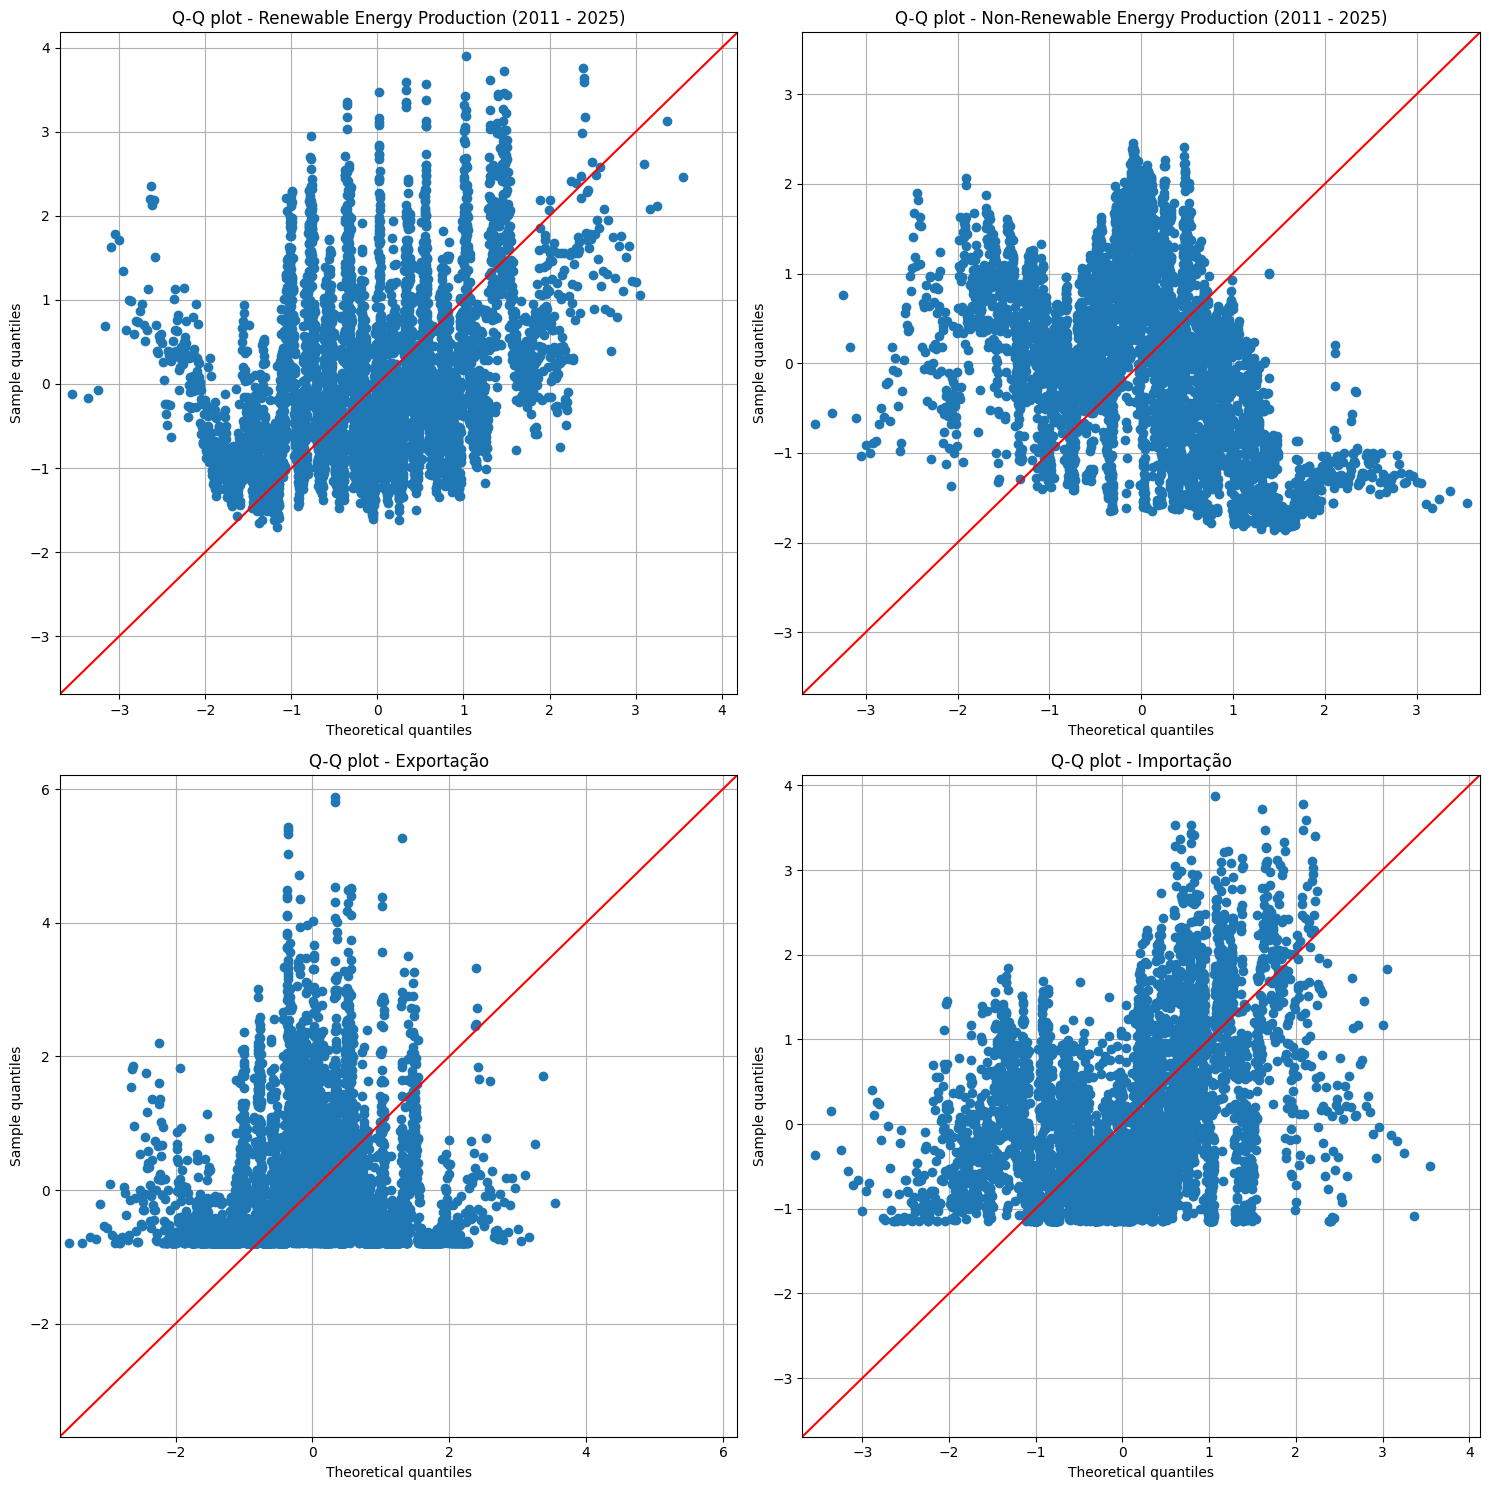

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Data for Q-Q plots
qqplot_data = [
    (df_renewable.values, title_renewable),
    (df_non_renewable.values, title_non_renewable),
    (df_export.values, 'Exportação'),
    (df_import.values, 'Importação')
]

# Loop through data to create Q-Q plots
for ax, (data, title) in zip(axes.flat, qqplot_data):
    qqplot(data, stats.distributions.norm, fit=True, line='45', ax=ax)
    ax.set_title(f'Q-Q plot - {title}')
    ax.set_ylabel('Sample quantiles')
    ax.set_xlabel('Theoretical quantiles')
    ax.grid(True)

plt.tight_layout()
plt.show()


### Quebras de estrutura 

Renewable Energy Production (2011 - 2025) - CUSUM Algorithm


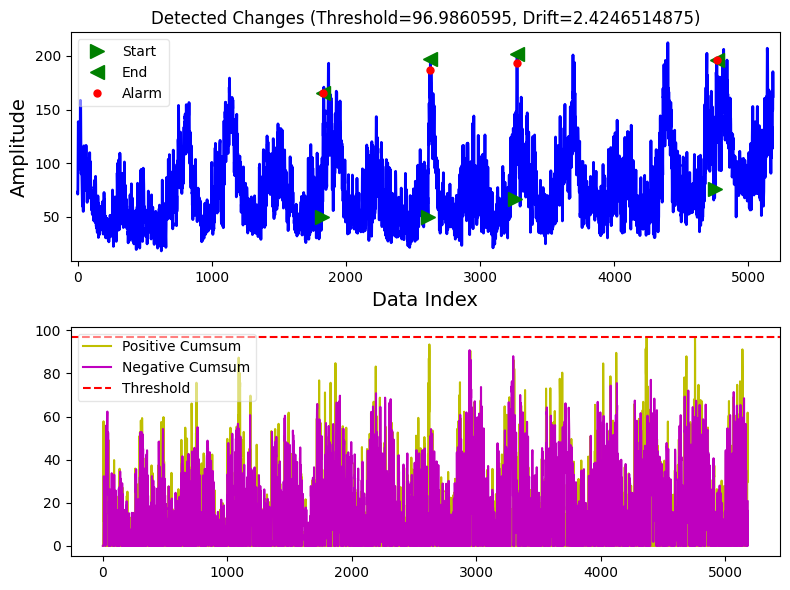

Non-Renewable Energy Production (2011 - 2025) - CUSUM Algorithm


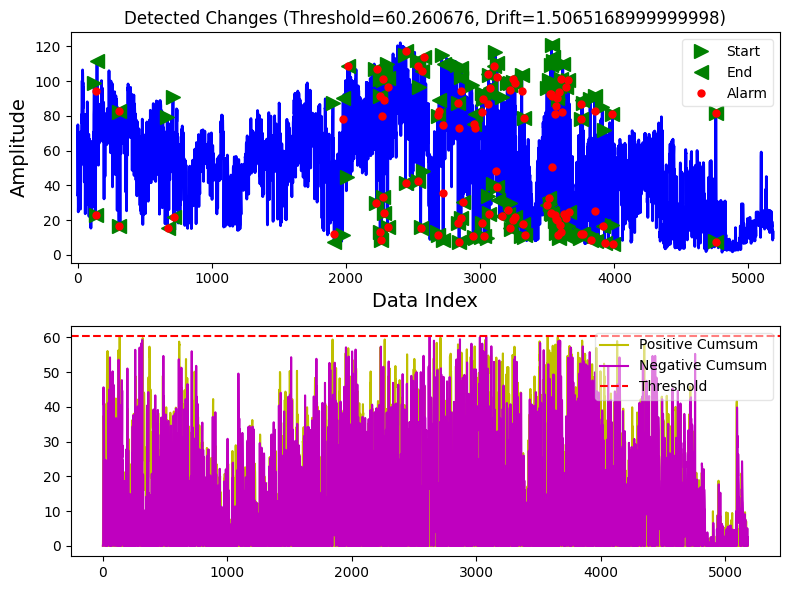

Exportação - CUSUM Algorithm


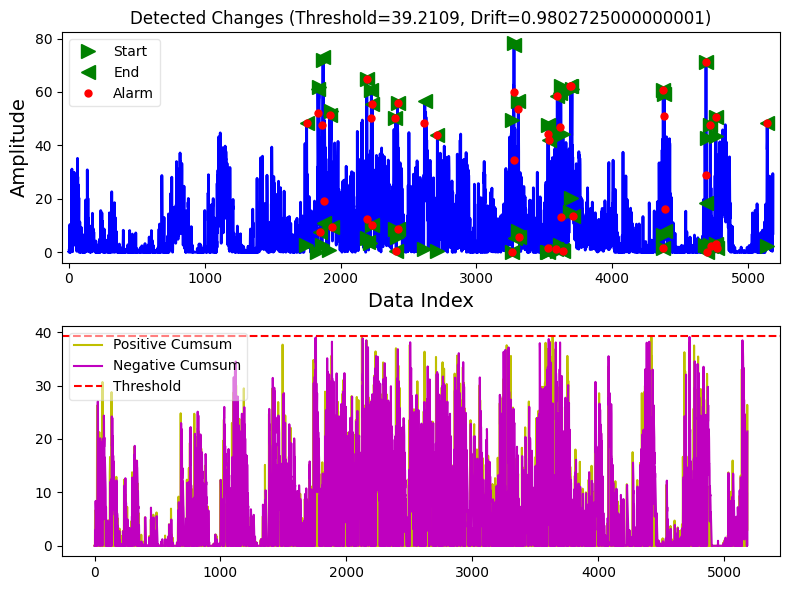

Importação - CUSUM Algorithm


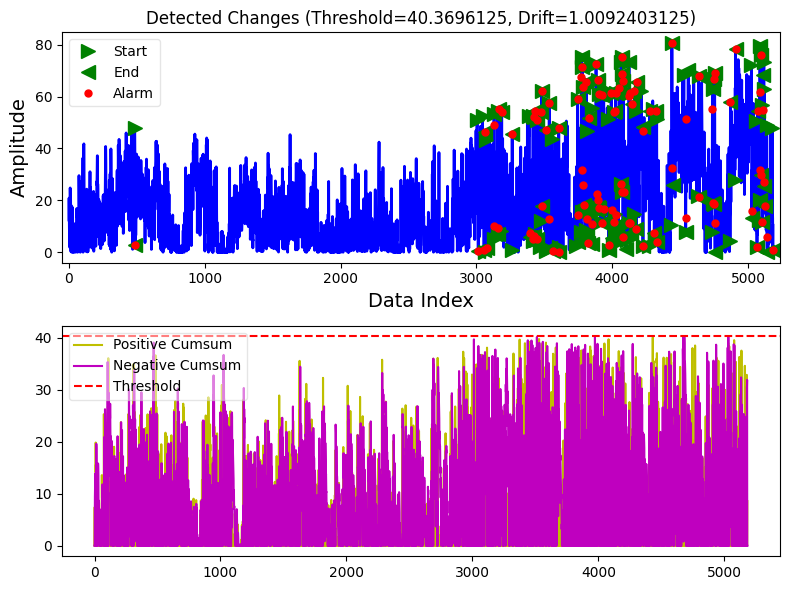

In [56]:
# Suggestions (attention to seasonal series)
# Define a function to calculate threshold and drift, and apply the CUSUM algorithm
def apply_cusum(data, title, color):
    threshold = (data.values.max() - data.values.min()) / 2
    drift = (data.values.max() - data.values.min()) / 80
    print(f"{title} - CUSUM Algorithm")
    detect_cusum(data=data.values, threshold=threshold, drift=drift, estimate_end=True, plot=True)

# Apply the function for each series
apply_cusum(df_renewable, title_renewable, color_renewable)
apply_cusum(df_non_renewable, title_non_renewable, color_non_renewable)
apply_cusum(df_export, "Exportação", color_export)
apply_cusum(df_import, "Importação", color_import)

# Análise inferencial

#### testar se a kurtuse da nossa serie segue uma distribuição normal
    - h0 : A kurtose da série segue uma distribuição normal. 
    - h1 : A kurtose da série não segue uma distribuição normal.

    rejeitamos h0 caso p-value seja inferior a 0.05

In [62]:
def perform_kurtosis_test(data, title):
    """Perform kurtosis test and print results."""
    k, kpval = kurtosistest(data)
    kurtosis_val = kurtosis(data, fisher=True)

    print(f"Kurtosis Test for {title}")
    print(f"Statistic: {k[0]:.4f}")
    print(f"p-value: {kpval[0]:.4f}")
    print(f"Kurtosis value: {kurtosis_val[0]:.4f}")

    if kpval[0] < 0.05:
        print("H0 rejected: The kurtosis of the series does not follow a normal distribution.")
    else:
        print("Failed to reject H0: The kurtosis of the series follows a normal distribution.")
    print("\n")

# Perform kurtosis tests for all series
perform_kurtosis_test(df_renewable, serie_renewable)
perform_kurtosis_test(df_non_renewable, serie_non_renewable)
perform_kurtosis_test(df_export, "Exportação")
perform_kurtosis_test(df_import, "Importação")


Kurtosis Test for Energy Renewable
Statistic: 6.1621
p-value: 0.0000
Kurtosis value: 0.5181
H0 rejected: The kurtosis of the series does not follow a normal distribution.


Kurtosis Test for Energy Non-Renewable
Statistic: -21.6436
p-value: 0.0000
Kurtosis value: -0.8147
H0 rejected: The kurtosis of the series does not follow a normal distribution.


Kurtosis Test for Exportação
Statistic: 19.8638
p-value: 0.0000
Kurtosis value: 3.2107
H0 rejected: The kurtosis of the series does not follow a normal distribution.


Kurtosis Test for Importação
Statistic: 4.2050
p-value: 0.0000
Kurtosis value: 0.3269
H0 rejected: The kurtosis of the series does not follow a normal distribution.




#### testar se a skew da nossa serie segue uma distribuição normal
    - h0 : A skew da série segue uma distribuição normal.
    - h1 : A skew da série não segue uma distribuição normal.

    rejeitamos h0 caso p-value seja inferior a 0.05


In [66]:
def perform_skewness_test(data, title):
    """Perform skewness test and print results."""
    s, spval = skewtest(data)
    skew_val = skew(data)
    print(f"Skew Test for {title}")
    print(f"Statistic: {s[0]:.4f}")
    print(f"p-value: {spval[0]:.4f}")
    print(f"Skewness value: {skew_val[0]:.4f}")
    
    if spval[0] < 0.05:
        print("H0 rejected: The skewness of the series does not follow a normal distribution.")
    else:
        print("Failed to reject H0: The skewness of the series follows a normal distribution.")
    print("\n")

# Perform skewness tests for all series
perform_skewness_test(df_renewable, serie_renewable)
perform_skewness_test(df_non_renewable, serie_non_renewable)
perform_skewness_test(df_export, "Exportação")
perform_skewness_test(df_import, "Importação")

Skew Test for Energy Renewable
Statistic: 24.0712
p-value: 0.0000
Skewness value: 0.9608
H0 rejected: The skewness of the series does not follow a normal distribution.


Skew Test for Energy Non-Renewable
Statistic: 0.9778
p-value: 0.3282
Skewness value: 0.0332
Failed to reject H0: The skewness of the series follows a normal distribution.


Skew Test for Exportação
Statistic: 35.8863
p-value: 0.0000
Skewness value: 1.7229
H0 rejected: The skewness of the series does not follow a normal distribution.


Skew Test for Importação
Statistic: 24.1659
p-value: 0.0000
Skewness value: 0.9658
H0 rejected: The skewness of the series does not follow a normal distribution.




#### testar se a série segue uma distribuição normal com o teste Jarque-Bera
- h0 : A série segue uma distribuição normal.
- h1 : A série não segue uma distribuição normal.


Rejeitamos h0 caso o p-value seja inferior a 0.05

In [68]:
# Jarque-Bera goodness of fit test for all series
series = [
    (df_renewable, serie_renewable),
    (df_non_renewable, serie_non_renewable),
    (df_export, "Exportação"),
    (df_import, "Importação")
]

for data, title in series:
    jb_stat, jb_pval = stats.jarque_bera(data)
    print(f"Jarque-Bera Test for {title}")
    print(f"Statistic: {jb_stat:.4f}")
    print(f"p-value: {jb_pval:.4f}")
    
    if jb_pval < 0.05:
        print("H0 rejected: The series does not follow a normal distribution.\n")
    else:
        print("Failed to reject H0: The series follows a normal distribution.\n")


Jarque-Bera Test for Energy Renewable
Statistic: 855.5961
p-value: 0.0000
H0 rejected: The series does not follow a normal distribution.

Jarque-Bera Test for Energy Non-Renewable
Statistic: 144.3322
p-value: 0.0000
H0 rejected: The series does not follow a normal distribution.

Jarque-Bera Test for Exportação
Statistic: 4791.3557
p-value: 0.0000
H0 rejected: The series does not follow a normal distribution.

Jarque-Bera Test for Importação
Statistic: 828.9632
p-value: 0.0000
H0 rejected: The series does not follow a normal distribution.




#### Teste de Hipótese para o Teste de Dickey-Fuller Aumentado (ADF)

- Hipótese Nula (H0): A série temporal possui uma raiz unitária, ou seja, não é estacionária.
- Hipótese Alternativa (H1): A série temporal não possui uma raiz unitária, ou seja, é estacionária.

Rejeitamos H0 caso o valor-p seja inferior a 0.05.


In [73]:
# Function to perform Augmented Dickey-Fuller Test
def perform_adf_test(data, series_name):
    result = adfuller(data.values.flatten(), regression='c')
    print(f"Augmented Dickey-Fuller Test for {series_name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Used lags: {result[2]}")
    print(f"Num obs: {result[3]}")
    critical_values = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
    for key, value in critical_values.items():
        print(f"\t{key}: {value:.3f}")
    
    # H0 hypothesis check
    if result[1] < 0.05:
        print("H0 rejected: The series is stationary.\n")
    else:
        print("Failed to reject H0: The series is not stationary.\n")

# Perform ADF tests for all series
perform_adf_test(df_renewable, serie_renewable)
perform_adf_test(df_non_renewable, serie_non_renewable)
perform_adf_test(df_export, serie_export)
perform_adf_test(df_import, serie_import)


Augmented Dickey-Fuller Test for Energy Renewable
ADF Statistic: -4.8054
p-value: 0.0001
Used lags: 29
Num obs: 5154
	1%: -3.432
	5%: -2.862
	10%: -2.567
H0 rejected: The series is stationary.

Augmented Dickey-Fuller Test for Energy Non-Renewable
ADF Statistic: -3.6574
p-value: 0.0048
Used lags: 33
Num obs: 5150
	1%: -3.432
	5%: -2.862
	10%: -2.567
H0 rejected: The series is stationary.

Augmented Dickey-Fuller Test for Energy Exportation
ADF Statistic: -5.9430
p-value: 0.0000
Used lags: 31
Num obs: 5152
	1%: -3.432
	5%: -2.862
	10%: -2.567
H0 rejected: The series is stationary.

Augmented Dickey-Fuller Test for Energy Importation
ADF Statistic: -4.8109
p-value: 0.0001
Used lags: 33
Num obs: 5150
	1%: -3.432
	5%: -2.862
	10%: -2.567
H0 rejected: The series is stationary.




#### Teste de Hipótese para o Teste KPSS

- Hipótese Nula (H0): A série temporal é estacionária.
- Hipótese Alternativa (H1):  A série temporal não é estacionária.

Rejeitamos H0 caso o valor-p seja inferior a 0.05.
```

In [82]:
def perform_kpss_test(data, series_name):
    """Perform KPSS test and print results."""
    result = kpss(data.values, regression='c')
    print(f"Kwiatkowski-Phillips-Schmidt-Shin Test for {series_name}")
    print(f"KPSS Statistic: {result[0]:.4f}")
    print("Critical Values:")
    critical_values = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
    for key, value in critical_values.items():
        print(f"\t{key}: {value:.3f}")
    
    # H0 hypothesis check
    # Compare the KPSS statistic with the critical value at the 5% significance level
    if result[0] > result[3]['5%']:
        print("H0 rejected: The series is not stationary.\n")
    else:
        print("Failed to reject H0: The series is stationary.\n")

# Perform KPSS tests for all series
perform_kpss_test(df_renewable, serie_renewable)
perform_kpss_test(df_non_renewable, serie_non_renewable)
perform_kpss_test(df_export, serie_export)
perform_kpss_test(df_import, serie_import)


Kwiatkowski-Phillips-Schmidt-Shin Test for Energy Renewable
KPSS Statistic: 1.6225
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347
H0 rejected: The series is not stationary.

Kwiatkowski-Phillips-Schmidt-Shin Test for Energy Non-Renewable
KPSS Statistic: 4.1529
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347
H0 rejected: The series is not stationary.

Kwiatkowski-Phillips-Schmidt-Shin Test for Energy Exportation
KPSS Statistic: 0.8643
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347
H0 rejected: The series is not stationary.

Kwiatkowski-Phillips-Schmidt-Shin Test for Energy Importation
KPSS Statistic: 4.5700
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347
H0 rejected: The series is not stationary.

